#Author: Md Mintu Miah, PhD; Post Doctoral Researcher at PATH, UC Berkeley
#Project: Contract 65A0911: Complete Cities: Bicycle Network Connectivity Evaluation Methodology
#PI: Alex Skabardonis, PhD, Professor, UC Berkeley

In [1]:
#!pip install pybna # if you need to install please remove comment out

In [2]:
# if you need to install please remove comment out
#!pip install -r requirements.txt
#!pip install SQLAlchemy
#!pip install momepy

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from collections.abc import Mapping
from distutils.version import LooseVersion
from pybna import Importer
import geopandas as gpd
import pybna

C:\Users\mmmiah\.conda\envs\geo_env\lib\site-packages\geopandas\_compat.py:112: UserWarning: The Shapely GEOS version (3.11.0-CAPI-1.17.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.3-CAPI-1.16.1). Conversions between both will be slow.
  warnings.warn(
C:\Users\mmmiah\.conda\envs\geo_env\lib\site-packages\pybna\conf.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
  from collections import Mapping


In [3]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import shape
import fiona
from shapely.ops import unary_union
import networkx as nx
import itertools
import osmnx as ox
import math
import momepy
import matplotlib.pyplot as plt
from shapely.geometry import Point
import io

In [4]:

from shapely.geometry import Polygon
import numpy as np
from shapely.geometry import Point
from functools import reduce
#import matplotlib.pyplot as plt  ## not needed
from shapely.geometry import Point, Polygon, MultiPolygon, LineString
import csv
from time import time
import time
from geopandas import GeoSeries, GeoDataFrame

In [ ]:
#conda install arcpy=3.0 -c esri

In [ ]:
#import arcpy
#from arcpy import env

In [ ]:
%%time
# Import Configuration file
i = pybna.Importer(config="config.yaml")
# Import Study Area boundary shape file
i.import_boundary('geo_export_b69ec18e-6a40-4637-94f6-1f3aafe63144.shp', overwrite=True)
# Mention the State fips, for California it is 6
i.import_census_blocks(fips=6, overwrite=True)
i.import_census_jobs("received.neighborhood_census_block_jobs",state="CA", overwrite=True)

In [ ]:
%%time
i.import_osm_network(overwrite=True)

In [ ]:
%%time
#Increase the timeout in your importer file if your computer is weak to avoid error
#i.import_osm_destinations(overwrite=True)


In [ ]:
%%time
# stress
s = pybna.Stress(config='config.yaml')
s.segment_stress()
s.crossing_stress()

In [ ]:
#%%time
# connectivity
#bna = pybna.pyBNA(config='config.yaml')
#bna.calculate_connectivity()

In [ ]:
#%%time
# scores
#bna.score("myschema.my_scores_table")
#bna.aggregate("myschema.my_aggregate_score_table")

In [5]:
# Read the LTS shape file
lts0=gpd.read_file("H:/Desktop/Bicycle Connectivity Project/Project-Bicycle Connectivity/Bay Area_LTS/neighborhood_ways.shp")
lts0 = lts0.rename(columns={'OSMID':'osmid'})
lts0=lts0.rename({'INTERSECTI':'u', 'INTERSE_01':'v'}, axis='columns')
lts0['length']=lts0.length
lts0.head()

,ROAD_ID,osmid,FUNCTIONAL,PATH_ID,ONE_WAY,u,v,WIDTH,SPEED_LIMI,FT_BIKE_IN,...,TWLTL_CROS,FT_PARK,TF_PARK,FT_SEG_STR,FT_INT_STR,TF_SEG_STR,TF_INT_STR,XWALK,geometry,length
0,111276,{31439803},tertiary,None,ft,419038,419030,NaN,NaN,None,...,None,?,?,4.0,NaN,NaN,3.0,None,"LINESTRING (91536.677 -976.326, 91560.948 -973...",24.398252
1,162454,{93291777},tertiary,None,ft,364379,364375,NaN,NaN,None,...,None,?,?,4.0,1.0,NaN,1.0,None,"LINESTRING (108350.827 -24102.437, 108425.349 ...",75.902661
2,165633,{184388728},primary,None,ft,329656,329657,NaN,35.0,None,...,None,?,?,4.0,1.0,NaN,1.0,None,"LINESTRING (94730.324 -23220.754, 94768.157 -2...",37.835842
3,888344,{53726448},tertiary,None,ft,76716,76717,NaN,NaN,None,...,None,?,?,4.0,1.0,NaN,1.0,None,"LINESTRING (65934.473 27367.107, 65935.819 273...",1.539394
4,923150,{655711604},residential,None,ft,129104,129102,NaN,NaN,None,...,None,?,?,1.0,NaN,NaN,NaN,None,"LINESTRING (41921.847 57781.540, 41918.170 577...",3.697954


C:\Users\mmmiah\AppData\Local\Temp\ipykernel_16188\4011393686.py:5: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_bd1=gpd.GeoDataFrame.explode(sf_bd)


<AxesSubplot:>

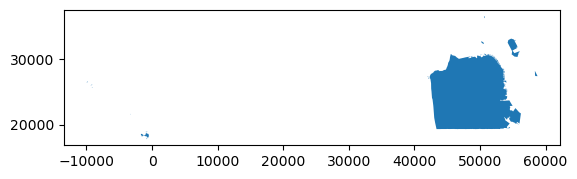

In [6]:
# read the bay area county boundary shape file
study_bd=gpd.read_file("H:/Desktop/Bicycle Connectivity Project/Project-Bicycle Connectivity/Bay Area_LTS/geo_export_b69ec18e-6a40-4637-94f6-1f3aafe63144.shp")
# lets consider only Alameda for now
sf_bd=study_bd.loc[study_bd['county']=='San Francisco']
sf_bd1=gpd.GeoDataFrame.explode(sf_bd)
sf_bd_proj = sf_bd1.to_crs(epsg=7131)
sf_bd_proj.plot()

In [13]:
lts1=gpd.clip(lts0,sf_bd_proj )

In [9]:
# import crossing identification buffer
buffer=gpd.read_file('H:/Desktop/Bicycle Connectivity Project/Project-Bicycle Connectivity/Bay Area_LTS/Bay_Area_intersection_buffer.shp')
buffer

,Shape_Leng,Shape_Area,geometry
0,2.943899e+07,1.327150e+09,"MULTIPOLYGON (((54315.992 -38938.931, 54322.94..."


In [10]:
buffer1=gpd.clip(buffer,sf_bd_proj)
buffer1

,Shape_Leng,Shape_Area,geometry
0,2.943899e+07,1.327150e+09,"MULTIPOLYGON (((46542.219 19473.532, 46549.077..."


In [11]:
def stress(FT_INT_STR,TF_INT_STR):
    if FT_INT_STR>0:
        return FT_INT_STR
    else:
        return TF_INT_STR
    
def stress2(Stress1,FT_SEG_STR):
    if Stress1>0:
        return Stress1
    else:
        return FT_SEG_STR

In [14]:
crossing_seg=gpd.clip(lts0,buffer1)
crossing_seg['Stress1']=crossing_seg.apply(lambda row:stress(row['FT_INT_STR'],row['TF_INT_STR']),axis=1)
crossing_seg['Stress']=crossing_seg.apply(lambda row:stress2(row['Stress1'],row['FT_SEG_STR']),axis=1)
crossing_seg=crossing_seg.drop(['Stress1'],axis=1)
crossing_seg.head(10)

,ROAD_ID,osmid,FUNCTIONAL,PATH_ID,ONE_WAY,u,v,WIDTH,SPEED_LIMI,FT_BIKE_IN,...,FT_PARK,TF_PARK,FT_SEG_STR,FT_INT_STR,TF_SEG_STR,TF_INT_STR,XWALK,geometry,length,Stress
263283,918176,{287653454},path,None,None,107516,107517,NaN,NaN,path,...,?,?,1.0,1.0,1.0,1.0,None,"LINESTRING (43314.360 20024.235, 43312.129 200...",22.655456,1.0
265885,918177,{287653454},path,None,None,107516,107517,NaN,NaN,path,...,?,?,1.0,1.0,1.0,1.0,None,"LINESTRING (43314.360 20024.235, 43313.375 200...",10.679609,1.0
4037,918179,{287653461},path,None,None,107518,107517,NaN,NaN,path,...,?,?,1.0,1.0,1.0,NaN,None,"LINESTRING (43306.516 20046.060, 43307.361 200...",17.253511,1.0
111693,958473,{506575391},path,None,None,107519,107515,NaN,NaN,path,...,?,?,1.0,1.0,1.0,NaN,None,"LINESTRING (43440.816 20067.119, 43453.976 200...",131.803597,1.0
731,850531,"{89770058,397084691,284557517}",primary,None,ft,103294,103290,NaN,50.0,lane,...,?,?,4.0,NaN,NaN,NaN,None,"MULTILINESTRING ((43319.112 21173.421, 43320.5...",666.102808,4.0
500445,832633,{371708157},path,None,None,102619,102620,NaN,NaN,path,...,?,?,1.0,NaN,1.0,NaN,None,"LINESTRING (42833.132 23900.282, 42838.262 239...",10.782725,1.0
379140,832634,{8920124},primary,None,ft,102609,102620,NaN,35.0,None,...,?,?,4.0,NaN,NaN,NaN,None,"MULTILINESTRING ((42801.807 24313.960, 42807.9...",414.645206,4.0
393341,844412,{48980820},primary,None,ft,102621,102610,NaN,35.0,None,...,?,?,4.0,NaN,NaN,NaN,None,"MULTILINESTRING ((42854.409 23902.433, 42848.1...",414.803845,4.0
474222,887195,"{48435314,371708147}",path,None,None,102611,102609,NaN,NaN,path,...,?,?,1.0,NaN,1.0,NaN,None,"LINESTRING (42791.979 24311.547, 42797.920 243...",10.175987,1.0
273506,844467,"{8929960,8930305,8922380,8922382}",residential,None,None,96738,96737,NaN,NaN,None,...,?,?,1.0,1.0,1.0,1.0,None,"MULTILINESTRING ((49921.420 19452.098, 49925.5...",271.160957,1.0


In [15]:
seg = lts1.overlay(crossing_seg, how='difference')
seg['Stress']=seg['FT_SEG_STR']
seg.head()

,ROAD_ID,osmid,FUNCTIONAL,PATH_ID,ONE_WAY,u,v,WIDTH,SPEED_LIMI,FT_BIKE_IN,...,FT_PARK,TF_PARK,FT_SEG_STR,FT_INT_STR,TF_SEG_STR,TF_INT_STR,XWALK,geometry,length,Stress
0,958473,{506575391},path,None,None,107519,107515,NaN,NaN,path,...,?,?,1.0,1.0,1.0,NaN,None,"LINESTRING (43382.729 20038.659, 43389.392 200...",131.803597,1.0
1,850531,"{89770058,397084691,284557517}",primary,None,ft,103294,103290,NaN,50.0,lane,...,?,?,4.0,NaN,NaN,NaN,None,"MULTILINESTRING ((43327.749 21122.260, 43332.1...",666.102808,4.0
2,832634,{8920124},primary,None,ft,102609,102620,NaN,35.0,None,...,?,?,4.0,NaN,NaN,NaN,None,"MULTILINESTRING ((42801.807 24313.960, 42824.4...",414.645206,4.0
3,844412,{48980820},primary,None,ft,102621,102610,NaN,35.0,None,...,?,?,4.0,NaN,NaN,NaN,None,"LINESTRING (42854.409 23902.433, 42812.109 243...",414.803845,4.0
4,868894,"{833341986,396938388,133354895}",primary,None,ft,107460,107311,NaN,55.0,None,...,?,?,4.0,NaN,NaN,NaN,None,"LINESTRING (43750.290 19550.253, 43749.705 195...",833.932331,4.0


In [16]:
lts=pd.concat([crossing_seg,seg],axis=0)
lts=gpd.GeoDataFrame.explode(lts).reset_index()
lts.head()

C:\Users\mmmiah\AppData\Local\Temp\ipykernel_16188\3177649857.py:2: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  lts=gpd.GeoDataFrame.explode(lts).reset_index()


,level_0,level_1,ROAD_ID,osmid,FUNCTIONAL,PATH_ID,ONE_WAY,u,v,WIDTH,...,FT_PARK,TF_PARK,FT_SEG_STR,FT_INT_STR,TF_SEG_STR,TF_INT_STR,XWALK,length,Stress,geometry
0,263283,0,918176,{287653454},path,None,None,107516,107517,NaN,...,?,?,1.0,1.0,1.0,1.0,None,22.655456,1.0,"LINESTRING (43314.360 20024.235, 43312.129 200..."
1,265885,0,918177,{287653454},path,None,None,107516,107517,NaN,...,?,?,1.0,1.0,1.0,1.0,None,10.679609,1.0,"LINESTRING (43314.360 20024.235, 43313.375 200..."
2,4037,0,918179,{287653461},path,None,None,107518,107517,NaN,...,?,?,1.0,1.0,1.0,NaN,None,17.253511,1.0,"LINESTRING (43306.516 20046.060, 43307.361 200..."
3,111693,0,958473,{506575391},path,None,None,107519,107515,NaN,...,?,?,1.0,1.0,1.0,NaN,None,131.803597,1.0,"LINESTRING (43440.816 20067.119, 43453.976 200..."
4,731,0,850531,"{89770058,397084691,284557517}",primary,None,ft,103294,103290,NaN,...,?,?,4.0,NaN,NaN,NaN,None,666.102808,4.0,"LINESTRING (43319.112 21173.421, 43320.506 211..."


# Lets calculate the slope for each link

In [17]:
#https://pysal.org/scipy2019-intermediate-gds/deterministic/gds2-rasters.html
import rasterio
from rasterio.plot import show
from rasterio import plot as rioplot
import matplotlib.pyplot as plt

In [18]:
# Open the raster image
barea_slope = rasterio.open('H:/Desktop/Bicycle Connectivity Project/Project-Bicycle Connectivity/Bay Area_LTS/Slope/Slope/cslope11.img')
print(barea_slope.crs)
#rioplot.show(barea_slope)

EPSG:4269


In [19]:
# only band is elev value (in m)
band1 = barea_slope.read(1, masked=True)  # mask noData cells [shouldn't be necessary on land]
stats = {'min': band1.min(), 'mean': band1.mean(), 'max': band1.max()}
print(stats)

{'min': -104, 'mean': -3.891794414661842, 'max': 1784}


In [20]:
# Reproject the geometries by replacing the values with projected ones
lts_new = lts.to_crs(epsg=4326)
lts_new.head(10)

,level_0,level_1,ROAD_ID,osmid,FUNCTIONAL,PATH_ID,ONE_WAY,u,v,WIDTH,...,FT_PARK,TF_PARK,FT_SEG_STR,FT_INT_STR,TF_SEG_STR,TF_INT_STR,XWALK,length,Stress,geometry
0,263283,0,918176,{287653454},path,None,None,107516,107517,NaN,...,?,?,1.0,1.0,1.0,1.0,None,22.655456,1.0,"LINESTRING (-122.50314 37.71417, -122.50317 37..."
1,265885,0,918177,{287653454},path,None,None,107516,107517,NaN,...,?,?,1.0,1.0,1.0,1.0,None,10.679609,1.0,"LINESTRING (-122.50314 37.71417, -122.50315 37..."
2,4037,0,918179,{287653461},path,None,None,107518,107517,NaN,...,?,?,1.0,1.0,1.0,NaN,None,17.253511,1.0,"LINESTRING (-122.50323 37.71436, -122.50322 37..."
3,111693,0,958473,{506575391},path,None,None,107519,107515,NaN,...,?,?,1.0,1.0,1.0,NaN,None,131.803597,1.0,"LINESTRING (-122.50171 37.71455, -122.50156 37..."
4,731,0,850531,"{89770058,397084691,284557517}",primary,None,ft,103294,103290,NaN,...,?,?,4.0,NaN,NaN,NaN,None,666.102808,4.0,"LINESTRING (-122.50310 37.72452, -122.50308 37..."
5,731,1,850531,"{89770058,397084691,284557517}",primary,None,ft,103294,103290,NaN,...,?,?,4.0,NaN,NaN,NaN,None,666.102808,4.0,"LINESTRING (-122.50075 37.72095, -122.50074 37..."
6,731,2,850531,"{89770058,397084691,284557517}",primary,None,ft,103294,103290,NaN,...,?,?,4.0,NaN,NaN,NaN,None,666.102808,4.0,"LINESTRING (-122.50036 37.71954, -122.50033 37..."
7,500445,0,832633,{371708157},path,None,None,102619,102620,NaN,...,?,?,1.0,NaN,1.0,NaN,None,10.782725,1.0,"LINESTRING (-122.50863 37.74909, -122.50857 37..."
8,379140,0,832634,{8920124},primary,None,ft,102609,102620,NaN,...,?,?,4.0,NaN,NaN,NaN,None,414.645206,4.0,"LINESTRING (-122.50899 37.75281, -122.50891 37..."
9,379140,1,832634,{8920124},primary,None,ft,102609,102620,NaN,...,?,?,4.0,NaN,NaN,NaN,None,414.645206,4.0,"LINESTRING (-122.50879 37.75127, -122.50870 37..."


In [21]:
# get the slope for each link of the network
%time
lts_new
# First identify the starting and ending node of each link
lts_new['starting point'] = None
lts_new['ending point'] = None

for index, row in lts_new.iterrows():
    coords = [(coords) for coords in list(row['geometry'].coords)]
    first_coord, last_coord = [ coords[i] for i in (0, -1) ]
    lts_new.at[index,'starting point'] = Point(first_coord)
    lts_new.at[index,'ending point'] = Point(last_coord)
    lts_new

CPU times: total: 0 ns
Wall time: 0 ns


In [22]:
lts_new.head(5)

,level_0,level_1,ROAD_ID,osmid,FUNCTIONAL,PATH_ID,ONE_WAY,u,v,WIDTH,...,FT_SEG_STR,FT_INT_STR,TF_SEG_STR,TF_INT_STR,XWALK,length,Stress,geometry,starting point,ending point
0,263283,0,918176,{287653454},path,None,None,107516,107517,NaN,...,1.0,1.0,1.0,1.0,None,22.655456,1.0,"LINESTRING (-122.50314 37.71417, -122.50317 37...",POINT (-122.50314150000001 37.7141678),POINT (-122.5032185 37.71423329999999)
1,265885,0,918177,{287653454},path,None,None,107516,107517,NaN,...,1.0,1.0,1.0,1.0,None,10.679609,1.0,"LINESTRING (-122.50314 37.71417, -122.50315 37...",POINT (-122.50314150000001 37.7141678),POINT (-122.5032185 37.71423329999999)
2,4037,0,918179,{287653461},path,None,None,107518,107517,NaN,...,1.0,1.0,1.0,NaN,None,17.253511,1.0,"LINESTRING (-122.50323 37.71436, -122.50322 37...",POINT (-122.5032306 37.7143644),POINT (-122.5032185 37.71423329999999)
3,111693,0,958473,{506575391},path,None,None,107519,107515,NaN,...,1.0,1.0,1.0,NaN,None,131.803597,1.0,"LINESTRING (-122.50171 37.71455, -122.50156 37...",POINT (-122.50170759024995 37.71455481311195),POINT (-122.5011292 37.714855500000006)
4,731,0,850531,"{89770058,397084691,284557517}",primary,None,ft,103294,103290,NaN,...,4.0,NaN,NaN,NaN,None,666.102808,4.0,"LINESTRING (-122.50310 37.72452, -122.50308 37...",POINT (-122.50309500000002 37.7245216),POINT (-122.50296976200676 37.7239816675655)


In [23]:
#lts_new['FUNCTIONAL'].unique()

<AxesSubplot:>

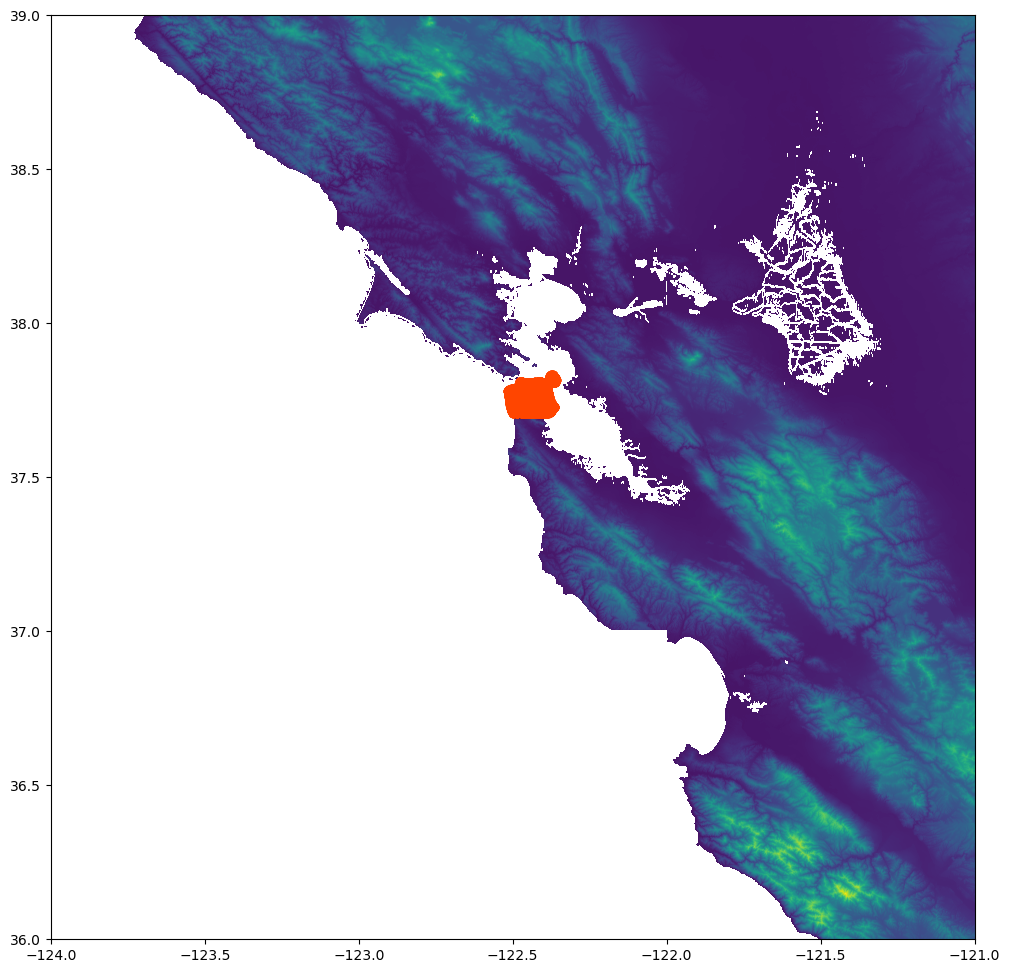

In [24]:
#show point and raster on a matplotlib plot
fig, ax = plt.subplots(figsize=(12,12))
lts_new.boundary.plot(ax=ax, color='orangered')
show(barea_slope, ax=ax)

In [25]:
# Calculate each link starting lat and long
sf1=lts_new.loc[:,["ROAD_ID","starting point"]]
sf1.columns=["ROAD_ID","geometry"]
sf1['start_lon'] = sf1.geometry.apply(lambda p: p.x)
sf1['start_lat'] = sf1.geometry.apply(lambda p: p.y)
sf2=sf1.loc[:,["ROAD_ID","geometry","start_lon","start_lat"]]
sf2.head(5)

,ROAD_ID,geometry,start_lon,start_lat
0,918176,POINT (-122.50314150000001 37.7141678),-122.503142,37.714168
1,918177,POINT (-122.50314150000001 37.7141678),-122.503142,37.714168
2,918179,POINT (-122.5032306 37.7143644),-122.503231,37.714364
3,958473,POINT (-122.50170759024995 37.71455481311195),-122.501708,37.714555
4,850531,POINT (-122.50309500000002 37.7245216),-122.503095,37.724522


In [26]:
# Calculate each link starting elevation
sf2["starting_ele"]= None
#point in test['geometry']:
x = sf2["start_lon"]
y = sf2["start_lat"]
row, col = barea_slope.index(x,y)
sf2["starting_ele"]=barea_slope.read(1)[row,col]

In [27]:
sf2.head()

,ROAD_ID,geometry,start_lon,start_lat,starting_ele
0,918176,POINT (-122.50314150000001 37.7141678),-122.503142,37.714168,56
1,918177,POINT (-122.50314150000001 37.7141678),-122.503142,37.714168,56
2,918179,POINT (-122.5032306 37.7143644),-122.503231,37.714364,58
3,958473,POINT (-122.50170759024995 37.71455481311195),-122.501708,37.714555,56
4,850531,POINT (-122.50309500000002 37.7245216),-122.503095,37.724522,15


In [28]:
%%time
# Calculate each link end point elevation
ef1=lts_new.loc[:,["ROAD_ID","ending point"]]
ef1.columns=["ROAD_ID","geometry"]
ef1['end_lon'] = ef1.geometry.apply(lambda p: p.x)
ef1['end_lat'] = ef1.geometry.apply(lambda p: p.y)
ef2=ef1.loc[:,["ROAD_ID","geometry","end_lon","end_lat"]]
ef2.head(5)

CPU times: total: 812 ms
Wall time: 789 ms


,ROAD_ID,geometry,end_lon,end_lat
0,918176,POINT (-122.5032185 37.71423329999999),-122.503219,37.714233
1,918177,POINT (-122.5032185 37.71423329999999),-122.503219,37.714233
2,918179,POINT (-122.5032185 37.71423329999999),-122.503219,37.714233
3,958473,POINT (-122.5011292 37.714855500000006),-122.501129,37.714856
4,850531,POINT (-122.50296976200676 37.7239816675655),-122.502970,37.723982


In [29]:
%%time
# Calculate the each link end elevation
ef2["ending_ele"]= None
#point in test['geometry']:
x = ef2["end_lon"]
y = ef2["end_lat"]
row, col = barea_slope.index(x,y)
ef2["ending_ele"]=barea_slope.read(1)[row,col]

CPU times: total: 3.36 s
Wall time: 3.36 s


In [30]:
lts_new.shape,sf2.shape,ef2.shape

((41061, 32), (41061, 5), (41061, 5))

In [31]:
%%time
# Calculate the slope for each link
from functools import reduce
barea_all=[sf2,ef2,lts_new]

barea_all1= reduce(lambda  left,right: pd.merge(left,right,on=['ROAD_ID'],
                                            how='outer'), barea_all).fillna('0')
barea_all1["slope"]=abs((barea_all1['starting_ele']-barea_all1['ending_ele'])/barea_all1['length'])*100
barea_all1=barea_all1.drop_duplicates(subset=['ROAD_ID'], keep='first')
barea_all1.head()

CPU times: total: 1 s
Wall time: 1.01 s


,ROAD_ID,geometry_x,start_lon,start_lat,starting_ele,geometry_y,end_lon,end_lat,ending_ele,level_0,...,FT_INT_STR,TF_SEG_STR,TF_INT_STR,XWALK,length,Stress,geometry,starting point,ending point,slope
0,918176,POINT (-122.50314150000001 37.7141678),-122.503142,37.714168,56,POINT (-122.5032185 37.71423329999999),-122.503219,37.714233,55,263283,...,1.0,1.0,1.0,0,22.655456,1.0,"LINESTRING (-122.50314 37.71417, -122.50317 37...",POINT (-122.50314150000001 37.7141678),POINT (-122.5032185 37.71423329999999),4.413948
1,918177,POINT (-122.50314150000001 37.7141678),-122.503142,37.714168,56,POINT (-122.5032185 37.71423329999999),-122.503219,37.714233,55,265885,...,1.0,1.0,1.0,0,10.679609,1.0,"LINESTRING (-122.50314 37.71417, -122.50315 37...",POINT (-122.50314150000001 37.7141678),POINT (-122.5032185 37.71423329999999),9.363638
2,918179,POINT (-122.5032306 37.7143644),-122.503231,37.714364,58,POINT (-122.5032185 37.71423329999999),-122.503219,37.714233,55,4037,...,1.0,1.0,0,0,17.253511,1.0,"LINESTRING (-122.50323 37.71436, -122.50322 37...",POINT (-122.5032306 37.7143644),POINT (-122.5032185 37.71423329999999),17.387765
3,958473,POINT (-122.50170759024995 37.71455481311195),-122.501708,37.714555,56,POINT (-122.5011292 37.714855500000006),-122.501129,37.714856,56,111693,...,1.0,1.0,0,0,131.803597,1.0,"LINESTRING (-122.50171 37.71455, -122.50156 37...",POINT (-122.50170759024995 37.71455481311195),POINT (-122.5011292 37.714855500000006),0.000000
11,850531,POINT (-122.50309500000002 37.7245216),-122.503095,37.724522,15,POINT (-122.50296976200676 37.7239816675655),-122.502970,37.723982,16,731,...,0,0,0,0,666.102808,4.0,"LINESTRING (-122.50310 37.72452, -122.50308 37...",POINT (-122.50309500000002 37.7245216),POINT (-122.50296976200676 37.7239816675655),0.150127


In [32]:
barea_all1.shape

(29407, 41)

In [33]:
barea_all1['slope'].describe()

count    2.940700e+04
mean     2.529134e+06
std      2.957238e+08
min      0.000000e+00
25%      0.000000e+00
50%      1.009782e+00
75%      4.298722e+00
max      4.825674e+10
Name: slope, dtype: float64

<AxesSubplot:>

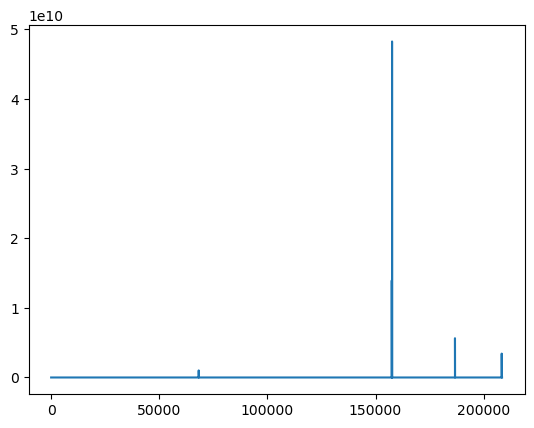

In [34]:
barea_all1.slope.plot()

In [35]:
# It seems that some of the slope is abnormal, due to mountain effect.

In [36]:
# Lets see the number of links that have slope greater than 100%
abnormal_slope=barea_all1.loc[barea_all1['slope']>100]
abnormal_slope.shape

(6, 41)

# Apply the slope effects for the LTS

In [37]:
abnormal_slope.columns

Index(['ROAD_ID', 'geometry_x', 'start_lon', 'start_lat', 'starting_ele',
       'geometry_y', 'end_lon', 'end_lat', 'ending_ele', 'level_0', 'level_1',
       'osmid', 'FUNCTIONAL', 'PATH_ID', 'ONE_WAY', 'u', 'v', 'WIDTH',
       'SPEED_LIMI', 'FT_BIKE_IN', 'FT_BIKE_01', 'TF_BIKE_IN', 'TF_BIKE_01',
       'FT_LANES', 'TF_LANES', 'FT_CROSS_L', 'TF_CROSS_L', 'TWLTL_CROS',
       'FT_PARK', 'TF_PARK', 'FT_SEG_STR', 'FT_INT_STR', 'TF_SEG_STR',
       'TF_INT_STR', 'XWALK', 'length', 'Stress', 'geometry', 'starting point',
       'ending point', 'slope'],
      dtype='object')

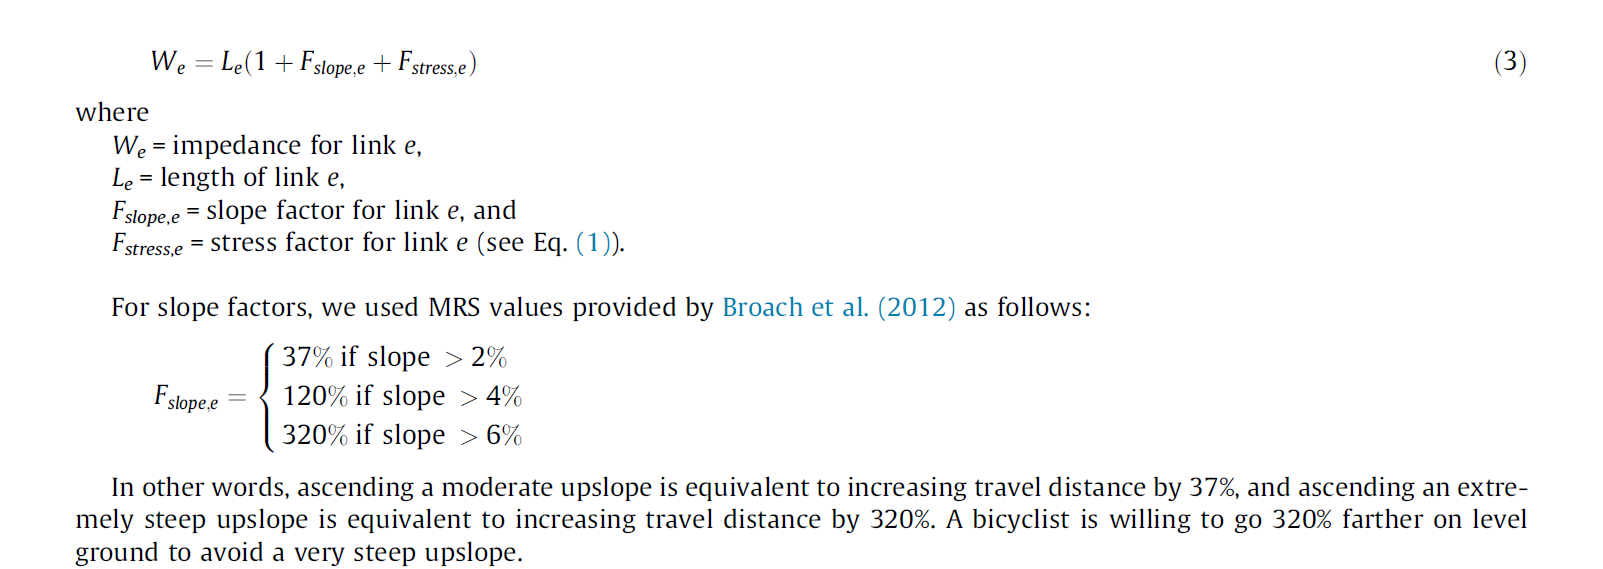

In [38]:
# write a slope impedance function
def slope_correction(length,Stress,slope):
    if slope <=2:
        return length*(1+Stress)
    elif ((slope>2) and (slope<=4)):
        return length*(1+0.37+Stress)
    elif ((slope>4) and (slope<=6)):
        return length*(1+1.20+Stress)
    else:
        return length*(1+3.20+Stress)

In [39]:
#barea_all1['FT_SEG_STR'].astype(str).astype(int)
barea_all1['Stress']=pd.to_numeric(barea_all1['Stress']).astype(int)
barea_all1['Stress'].dtypes

dtype('int32')

In [40]:
barea_all1['impedance_of_link']=barea_all1.apply(lambda row: slope_correction(row['length'],row['Stress'],row['slope']),axis=1)
barea_all1.head(8)

,ROAD_ID,geometry_x,start_lon,start_lat,starting_ele,geometry_y,end_lon,end_lat,ending_ele,level_0,...,TF_SEG_STR,TF_INT_STR,XWALK,length,Stress,geometry,starting point,ending point,slope,impedance_of_link
0,918176,POINT (-122.50314150000001 37.7141678),-122.503142,37.714168,56,POINT (-122.5032185 37.71423329999999),-122.503219,37.714233,55,263283,...,1.0,1.0,0,22.655456,1,"LINESTRING (-122.50314 37.71417, -122.50317 37...",POINT (-122.50314150000001 37.7141678),POINT (-122.5032185 37.71423329999999),4.413948,72.497459
1,918177,POINT (-122.50314150000001 37.7141678),-122.503142,37.714168,56,POINT (-122.5032185 37.71423329999999),-122.503219,37.714233,55,265885,...,1.0,1.0,0,10.679609,1,"LINESTRING (-122.50314 37.71417, -122.50315 37...",POINT (-122.50314150000001 37.7141678),POINT (-122.5032185 37.71423329999999),9.363638,55.533969
2,918179,POINT (-122.5032306 37.7143644),-122.503231,37.714364,58,POINT (-122.5032185 37.71423329999999),-122.503219,37.714233,55,4037,...,1.0,0,0,17.253511,1,"LINESTRING (-122.50323 37.71436, -122.50322 37...",POINT (-122.5032306 37.7143644),POINT (-122.5032185 37.71423329999999),17.387765,89.718260
3,958473,POINT (-122.50170759024995 37.71455481311195),-122.501708,37.714555,56,POINT (-122.5011292 37.714855500000006),-122.501129,37.714856,56,111693,...,1.0,0,0,131.803597,1,"LINESTRING (-122.50171 37.71455, -122.50156 37...",POINT (-122.50170759024995 37.71455481311195),POINT (-122.5011292 37.714855500000006),0.000000,263.607195
11,850531,POINT (-122.50309500000002 37.7245216),-122.503095,37.724522,15,POINT (-122.50296976200676 37.7239816675655),-122.502970,37.723982,16,731,...,0,0,0,666.102808,4,"LINESTRING (-122.50310 37.72452, -122.50308 37...",POINT (-122.50309500000002 37.7245216),POINT (-122.50296976200676 37.7239816675655),0.150127,3330.514041
136,832633,POINT (-122.5086268 37.74908700000001),-122.508627,37.749087,7,POINT (-122.5085052 37.74909759999999),-122.508505,37.749098,8,500445,...,1.0,0,0,10.782725,1,"LINESTRING (-122.50863 37.74909, -122.50857 37...",POINT (-122.5086268 37.74908700000001),POINT (-122.5085052 37.74909759999999),9.274093,56.070172
137,832634,POINT (-122.50898519999998 37.7528139),-122.508985,37.752814,9,POINT (-122.50891470343976 37.75226811874737),-122.508915,37.752268,9,379140,...,0,0,0,414.645206,4,"LINESTRING (-122.50899 37.75281, -122.50891 37...",POINT (-122.50898519999998 37.7528139),POINT (-122.50891470343976 37.75226811874737),0.000000,2073.226031
262,844412,POINT (-122.50838540000001 37.749106499999996),-122.508385,37.749106,8,POINT (-122.50845635033392 37.74965271932462),-122.508456,37.749653,9,393341,...,0,0,0,414.803845,4,"LINESTRING (-122.50839 37.74911, -122.50846 37...",POINT (-122.50838540000001 37.749106499999996),POINT (-122.50845635033392 37.74965271932462),0.241078,2074.019227


# Lets Calculate the Connectivity for SF

In [41]:
# Bring US Census track
census_track=gpd.read_file('H:/Desktop/Bicycle Connectivity Project/Project-Bicycle Connectivity/Bay Area_LTS/Bay_Area_Census_tracts.shp')
census_track.head()

,GISJOIN,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,Shape_Leng,Shape_Le_1,Shape_Area,geometry
0,G0600010400100,06,001,400100,06001400100,4001,Census Tract 4001,G5020,S,6945857.0,0.0,+37.8676563,-122.2318813,14242.773440,14242.773440,6.945853e+06,"POLYGON ((-2255573.793 353162.591, -2255577.88..."
1,G0600010400200,06,001,400200,06001400200,4002,Census Tract 4002,G5020,S,586560.0,0.0,+37.8481378,-122.2495916,3990.700032,3990.700032,5.865583e+05,"POLYGON ((-2258184.246 353217.527, -2258186.81..."
2,G0600010400300,06,001,400300,06001400300,4003,Census Tract 4003,G5020,S,1110840.0,0.0,+37.8405841,-122.2544782,5311.191050,5311.191050,1.110836e+06,"POLYGON ((-2259381.804 351835.858, -2259385.23..."
3,G0600010400400,06,001,400400,06001400400,4004,Census Tract 4004,G5020,S,716138.0,0.0,+37.8482840,-122.2574447,3812.082499,3812.082499,7.161367e+05,"POLYGON ((-2259084.126 353696.375, -2259085.36..."
4,G0600010400500,06,001,400500,06001400500,4005,Census Tract 4005,G5020,S,591424.0,0.0,+37.8485452,-122.2647353,3292.829056,3292.829056,5.914232e+05,"POLYGON ((-2259833.634 353763.276, -2259822.21..."


<AxesSubplot:>

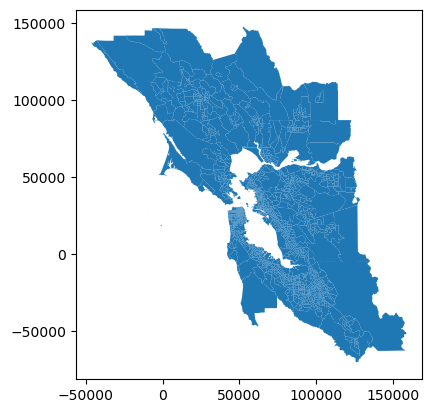

In [42]:
census_track1=census_track.to_crs(epsg=7131)
census_track1.plot()

In [43]:
sf_bd_proj['area']=sf_bd_proj['geometry'].area*3.861e-7 # mile square
sf_bd_proj

county fipsstco  objectid  \
4 0   San Francisco    06075       5.0   
  1   San Francisco    06075       5.0   
  2   San Francisco    06075       5.0   
  3   San Francisco    06075       5.0   
  4   San Francisco    06075       5.0   
  5   San Francisco    06075       5.0   
  6   San Francisco    06075       5.0   
  7   San Francisco    06075       5.0   
  8   San Francisco    06075       5.0   
  9   San Francisco    06075       5.0   
  10  San Francisco    06075       5.0   
  11  San Francisco    06075       5.0   
  12  San Francisco    06075       5.0   
  13  San Francisco    06075       5.0   
  14  San Francisco    06075       5.0   
  15  San Francisco    06075       5.0   
  16  San Francisco    06075       5.0   
  17  San Francisco    06075       5.0   
  18  San Francisco    06075       5.0   

                                               geometry       area  
4 0   POLYGON ((45588.708 30774.040, 45676.760 30751...  46.411539  
  1   POLYGON ((55292.672 32793.124, 55299.947 32730...   0.901069  
  2   POLYGON ((-605.543 18059.688, -730.704 18088.5...   0.105416  
  3   POLYGON ((58369.300 28238.464, 58775.552 27428...   0.057228  
  4   POLYGON ((-1692.967 18600.383, -1674.938 18635...   0.035705  
  5   POLYGON ((50493.151 32338.967, 50422.699 32405...   0.029466  
  6   POLYGON ((50650.362 36257.004, 50606.257 36589...   0.008391  
  7   POLYGON ((42167.574 27179.899, 42183.704 27191...   0.005559  
  8   POLYGON ((-9929.803 26618.248, -9896.513 26653...   0.004739  
  9   POLYGON ((-826.338 17845.212, -869.675 17825.1...   0.004219  
  10  POLYGON ((42095.118 27367.973, 42104.444 27350...   0.003183  
  11  POLYGON ((-841.897 18958.268, -828.974 18996.2...   0.003032  
  12  POLYGON ((-9231.547 26146.059, -9218.718 26166...   0.002353  
  13  POLYGON ((-9064.131 25712.886, -9081.947 25710...   0.002070  
  14  POLYGON ((-9356.826 26035.042, -9349.002 26057...   0.001755  
  15  POLYGON ((-3363.100 21620.186, -3352.772 21650...   0.001298  
  16  POLYGON ((54099.459 25137.599, 54081.680 25348...   0.001114  
  17  POLYGON ((-883.407 18828.869, -903.584 18846.8...   0.000786  
  18  POLYGON ((-999.818 18903.372, -999.759 18913.4...   0.000539

In [44]:
sf_area=sf_bd_proj[['area']].values
sf_area

array([[4.64115386e+01],
       [9.01069270e-01],
       [1.05416493e-01],
       [5.72284577e-02],
       [3.57054475e-02],
       [2.94662984e-02],
       [8.39072367e-03],
       [5.55909103e-03],
       [4.73850673e-03],
       [4.21875846e-03],
       [3.18346464e-03],
       [3.03229717e-03],
       [2.35302628e-03],
       [2.06973532e-03],
       [1.75499771e-03],
       [1.29849172e-03],
       [1.11397082e-03],
       [7.86341536e-04],
       [5.38560929e-04]])

In [45]:
# Convert to geodataframe
#abnormal_slope1=abnormal_slope.set_crs(epsg=4326)
#abnormal_slope2=abnormal_slope1.to_crs(epsg=7131)
barea_all2 = gpd.GeoDataFrame(barea_all1, crs="EPSG:4326", geometry='geometry')
barea_all3=barea_all2.to_crs(epsg=7131)
barea_all3.head()

,ROAD_ID,geometry_x,start_lon,start_lat,starting_ele,geometry_y,end_lon,end_lat,ending_ele,level_0,...,TF_SEG_STR,TF_INT_STR,XWALK,length,Stress,geometry,starting point,ending point,slope,impedance_of_link
0,918176,POINT (-122.50314150000001 37.7141678),-122.503142,37.714168,56,POINT (-122.5032185 37.71423329999999),-122.503219,37.714233,55,263283,...,1.0,1.0,0,22.655456,1,"LINESTRING (43314.360 20024.235, 43312.129 200...",POINT (-122.50314150000001 37.7141678),POINT (-122.5032185 37.71423329999999),4.413948,72.497459
1,918177,POINT (-122.50314150000001 37.7141678),-122.503142,37.714168,56,POINT (-122.5032185 37.71423329999999),-122.503219,37.714233,55,265885,...,1.0,1.0,0,10.679609,1,"LINESTRING (43314.360 20024.235, 43313.375 200...",POINT (-122.50314150000001 37.7141678),POINT (-122.5032185 37.71423329999999),9.363638,55.533969
2,918179,POINT (-122.5032306 37.7143644),-122.503231,37.714364,58,POINT (-122.5032185 37.71423329999999),-122.503219,37.714233,55,4037,...,1.0,0,0,17.253511,1,"LINESTRING (43306.516 20046.060, 43307.361 200...",POINT (-122.5032306 37.7143644),POINT (-122.5032185 37.71423329999999),17.387765,89.718260
3,958473,POINT (-122.50170759024995 37.71455481311195),-122.501708,37.714555,56,POINT (-122.5011292 37.714855500000006),-122.501129,37.714856,56,111693,...,1.0,0,0,131.803597,1,"LINESTRING (43440.816 20067.119, 43453.976 200...",POINT (-122.50170759024995 37.71455481311195),POINT (-122.5011292 37.714855500000006),0.000000,263.607195
11,850531,POINT (-122.50309500000002 37.7245216),-122.503095,37.724522,15,POINT (-122.50296976200676 37.7239816675655),-122.502970,37.723982,16,731,...,0,0,0,666.102808,4,"LINESTRING (43319.112 21173.421, 43320.506 211...",POINT (-122.50309500000002 37.7245216),POINT (-122.50296976200676 37.7239816675655),0.150127,3330.514041


In [46]:
# Now lets crop the alameda area of lTS network
sf_lts=gpd.clip(barea_all3,sf_bd_proj)
sf_lts.head()

,ROAD_ID,geometry_x,start_lon,start_lat,starting_ele,geometry_y,end_lon,end_lat,ending_ele,level_0,...,TF_SEG_STR,TF_INT_STR,XWALK,length,Stress,geometry,starting point,ending point,slope,impedance_of_link
2850,853001,POINT (-122.46287608754353 37.70833997898323),-122.462876,37.708340,127,POINT (-122.46271639871541 37.70823199806019),-122.462716,37.708232,129,146278,...,1.0,0,0,143.817146,1,"LINESTRING (46864.589 19376.143, 46878.669 193...",POINT (-122.46287608754353 37.70833997898323),POINT (-122.46271639871541 37.70823199806019),1.390655,287.634291
2858,850950,POINT (-122.46261275150326 37.708231998744914),-122.462613,37.708232,127,POINT (-122.4628324046153 37.70838161642227),-122.462832,37.708382,126,174969,...,0,1.0,0,240.618409,1,"LINESTRING (46887.809 19364.155, 46868.442 193...",POINT (-122.46261275150326 37.708231998744914),POINT (-122.4628324046153 37.70838161642227),0.415596,481.236818
207610,853406,POINT (-122.4639505 37.7085384),-122.463950,37.708538,139,POINT (-122.46399723613168 37.70824915319103),-122.463997,37.708249,142,174,...,1.0,0,0,118.313131,1,"LINESTRING (46769.851 19398.180, 46758.033 193...",POINT (-122.4639505 37.7085384),POINT (-122.46399723613168 37.70824915319103),2.535644,280.402120
886,845714,POINT (-122.46483102328091 37.70872775755747),-122.464831,37.708728,115,POINT (-122.4643725 37.709138100000004),-122.464372,37.709138,112,146233,...,1.0,0,0,373.773220,1,"LINESTRING (46692.210 19419.209, 46697.683 194...",POINT (-122.46483102328091 37.70872775755747),POINT (-122.4643725 37.709138100000004),0.802626,747.546440
2886,845713,POINT (-122.4643685 37.7089228),-122.464369,37.708923,117,POINT (-122.4643725 37.709138100000004),-122.464372,37.709138,112,65384,...,1.0,0,0,23.899128,1,"LINESTRING (46732.999 19440.851, 46732.649 194...",POINT (-122.4643685 37.7089228),POINT (-122.4643725 37.709138100000004),20.921265,124.275467


In [47]:
sf_lts.groupby(['FT_BIKE_IN']).count()

,ROAD_ID,geometry_x,start_lon,start_lat,starting_ele,geometry_y,end_lon,end_lat,ending_ele,level_0,...,TF_SEG_STR,TF_INT_STR,XWALK,length,Stress,geometry,starting point,ending point,slope,impedance_of_link
FT_BIKE_IN,,,,,,,,,,,,,,,,,,,,,
0,21371,21371,21371,21371,21371,21371,21371,21371,21371,21371,...,21371,21371,21371,21371,21371,21371,21371,21371,21371,21371
buffered_lane,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
lane,2374,2374,2374,2374,2374,2374,2374,2374,2374,2374,...,2374,2374,2374,2374,2374,2374,2374,2374,2374,2374
path,2052,2052,2052,2052,2052,2052,2052,2052,2052,2052,...,2052,2052,2052,2052,2052,2052,2052,2052,2052,2052
sharrow,2941,2941,2941,2941,2941,2941,2941,2941,2941,2941,...,2941,2941,2941,2941,2941,2941,2941,2941,2941,2941
track,667,667,667,667,667,667,667,667,667,667,...,667,667,667,667,667,667,667,667,667,667


In [48]:
sf_lts.crs

<Derived Projected CRS: EPSG:7131>
Name: NAD83(2011) / San Francisco CS13
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: United States (USA) - California - San Francisco bay area - counties of Alameda, Contra Costa, Marin, Napa, San Francisco, San Mateo, Santa Clara, Santa Cruz, Solano and Sonoma.
- bounds: (-123.56, 36.85, -121.2, 38.87)
Coordinate Operation:
- name: City and County of San Francisco CS13 (meters)
- method: Transverse Mercator
Datum: NAD83 (National Spatial Reference System 2011)
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [49]:
lts.shape

(41061, 30)

In [50]:
# Convert the LTS shape file to graph to run the 
sf_lts_g=gpd.GeoDataFrame.explode(sf_lts)
sf_lts_g1 =momepy.gdf_to_nx(sf_lts_g, approach='primal')

C:\Users\mmmiah\AppData\Local\Temp\ipykernel_16188\1286791951.py:2: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_g=gpd.GeoDataFrame.explode(sf_lts)


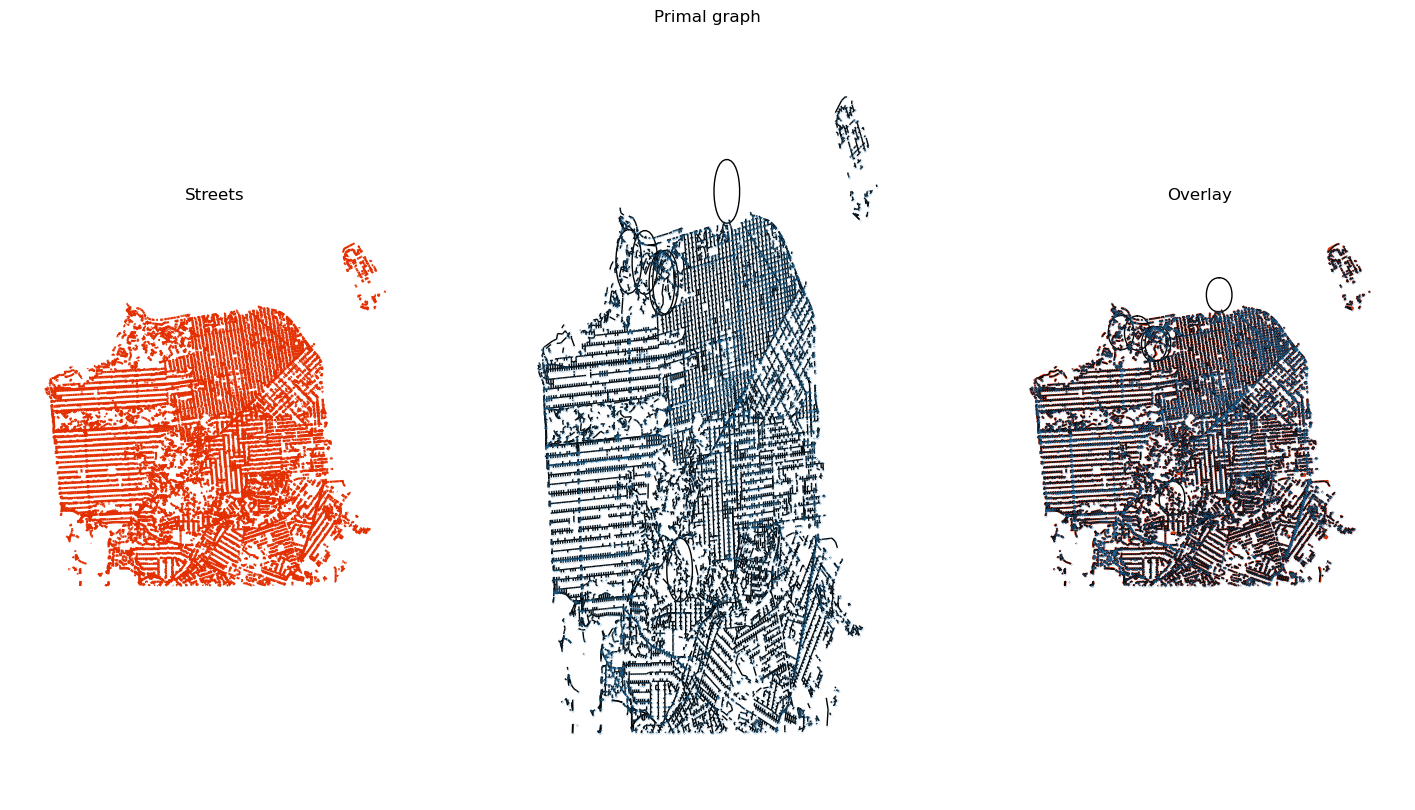

In [51]:
 f, ax = plt.subplots(1, 3, figsize=(18, 10), sharex=True, sharey=True)
 sf_lts.plot(color='#e32e00', ax=ax[0])
 for i, facet in enumerate(ax):
     facet.set_title(("Streets", "Primal graph", "Overlay")[i])
     facet.axis("off")
 nx.draw(sf_lts_g1, {n:[n[0], n[1]] for n in list(sf_lts_g1.nodes)}, ax=ax[1], node_size=0.01)
 sf_lts.plot(color='#e32e00', ax=ax[2], zorder=-1)
 nx.draw(sf_lts_g1, {n:[n[0], n[1]] for n in list(sf_lts_g1.nodes)}, ax=ax[2], node_size=0.01)

# Calculate Simple Graph Theories Connectivity for SF

<AxesSubplot:>

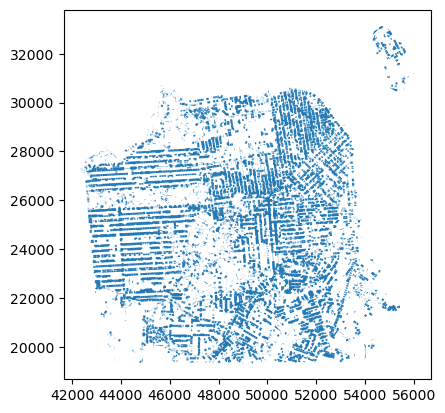

In [52]:
sf_lts['geometry'].convex_hull.plot()

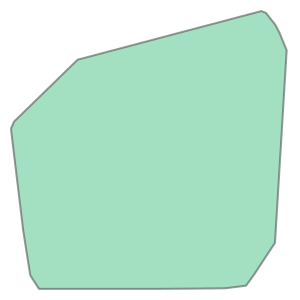

In [53]:
# Get the Convex Hull of the network
convex_hull_area = sf_lts.unary_union.convex_hull
# Show output
convex_hull_area

<AxesSubplot:>

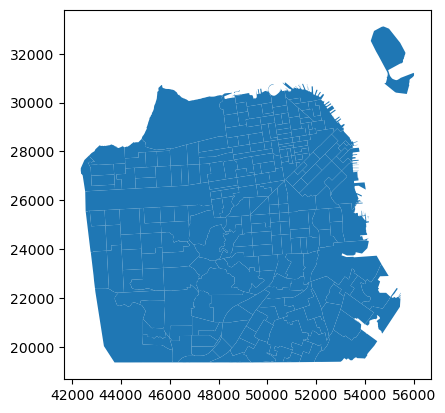

In [54]:
census_track2_sf=gpd.clip(census_track1,convex_hull_area)
census_track2_sf.plot()

In [55]:
convex_hull_area1=convex_hull_area.area
convex_hull_area1

152999891.33936366

In [56]:
# Calculate the number of Intersections
crossroad_nodes = [node for node in sf_lts_g1.nodes() if len(sf_lts_g1.edges(node)) > 2]


In [57]:
def get_number_of_elements(list):
    count = 0
    for element in list:
        count += 1
    return count

#print("Number of elements in the list: ", get_number_of_elements(list_c))

In [58]:
# Number of intersections where edge>2
NI=get_number_of_elements(crossroad_nodes)
NI

8143

# Calculate the Connectivity of the SF Network: using Formula "Shortest Path in bicycle facilities /Shortest Path in motor ways

In [59]:
sf_lts['FT_BIKE_IN'].dtypes

dtype('O')

<AxesSubplot:>

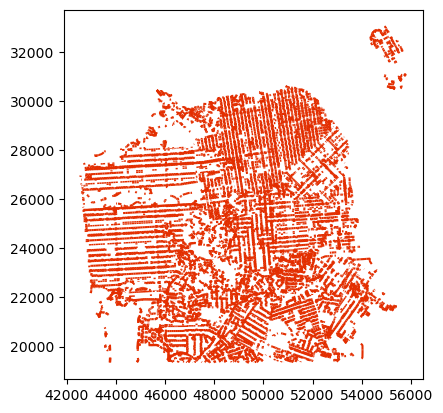

In [60]:
# Get the motorway network and bike network based on functional class of the roads
#sf_motor_network=sf_lts[sf_lts['BIKE_LANE_'].isna()]
sf_motor_network=sf_lts.loc[sf_lts['FT_BIKE_IN']=='0']
# Plot the motor Network
sf_motor_network.plot(color='#e32e00')

<AxesSubplot:>

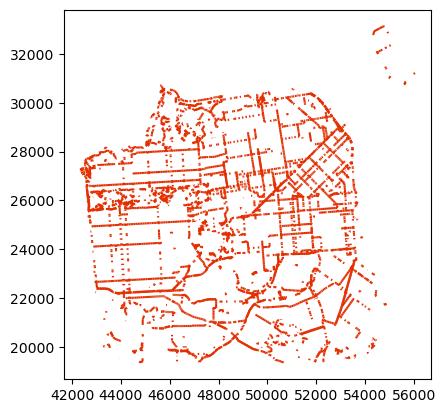

In [61]:
# Plot the Bike Network
sf_bike_network=sf_lts.loc[sf_lts['FT_BIKE_IN']!='0']
sf_bike_network.plot(color='#e32e00')

In [62]:
sf_lts.shape, sf_bike_network.shape, sf_motor_network.shape

((29407, 42), (8036, 42), (21371, 42))

In [63]:
sf_bike_network.tail()

,ROAD_ID,geometry_x,start_lon,start_lat,starting_ele,geometry_y,end_lon,end_lat,ending_ele,level_0,...,TF_SEG_STR,TF_INT_STR,XWALK,length,Stress,geometry,starting point,ending point,slope,impedance_of_link
206975,932214,POINT (-122.4157468 37.8089689),-122.415747,37.808969,3,POINT (-122.41506373665591 37.80905248676883),-122.415064,37.809052,3,356704,...,1.0,1.0,0,152.621817,1,"LINESTRING (51016.352 30545.693, 51017.547 305...",POINT (-122.4157468 37.8089689),POINT (-122.41506373665591 37.80905248676883),0.0,305.243635
206730,854699,POINT (-122.3711486 37.829681599999994),-122.371149,37.829682,3,POINT (-122.37147092800126 37.83016682634731),-122.371471,37.830167,3,213785,...,1.0,1.0,0,305.520757,1,"LINESTRING (54941.749 32847.052, 54913.327 329...",POINT (-122.3711486 37.829681599999994),POINT (-122.37147092800126 37.83016682634731),0.0,611.041513
208495,854696,POINT (-122.37524499999999 37.8313949),-122.375245,37.831395,3,POINT (-122.378156 37.8289994),-122.378156,37.828999,3,7641,...,1.0,0,0,396.153446,1,"LINESTRING (54580.966 33036.921, 54439.115 329...",POINT (-122.37524499999999 37.8313949),POINT (-122.378156 37.8289994),0.0,792.306893
208497,854693,POINT (-122.37524499999999 37.8313949),-122.375245,37.831395,3,POINT (-122.37360930000001 37.832084900000005),-122.373609,37.832085,3,7648,...,1.0,0,0,163.096094,1,"LINESTRING (54580.966 33036.921, 54724.901 331...",POINT (-122.37524499999999 37.8313949),POINT (-122.37360930000001 37.832084900000005),0.0,326.192188
208498,854694,POINT (-122.3728678 37.8320591),-122.372868,37.832059,3,POINT (-122.37360930000001 37.832084900000005),-122.373609,37.832085,3,7649,...,1.0,0,0,68.492499,1,"LINESTRING (54790.179 33110.814, 54785.573 331...",POINT (-122.3728678 37.8320591),POINT (-122.37360930000001 37.832084900000005),0.0,136.984998


In [64]:
def sf_connectivity_score (sf_motor_network,sf_bike_network):
    connectivity_score=[]
    sf_lts_motor_g=gpd.GeoDataFrame.explode(sf_motor_network)
    sf_lts_motor_g1 =momepy.gdf_to_nx(sf_lts_motor_g, approach='primal')
    #https://www.programcreek.com/python/example/120188/networkx.all_pairs_dijkstra_path_length
    motor_length = dict(nx.all_pairs_dijkstra_path_length(sf_lts_motor_g1,cutoff=None, weight='impedance_of_link'))
    # Convert the shorsted path distance distionary to dataframe
    sf_shortest_path_motor_length=pd.DataFrame.from_dict(motor_length)
    # Calculate the total motor path
    sf_shortest_path_motor_length['total']=sf_shortest_path_motor_length.sum(numeric_only=True, axis=0)
    sf_shortest_path_motor_length_sum=sf_shortest_path_motor_length['total'].sum()


    sf_lts_bike_g=gpd.GeoDataFrame.explode(sf_bike_network)
    sf_lts_bike_g1 =momepy.gdf_to_nx(sf_lts_bike_g, approach='primal')
    #https://www.programcreek.com/python/example/120188/networkx.all_pairs_dijkstra_path_length
    bike_length = dict(nx.all_pairs_dijkstra_path_length(sf_lts_bike_g1,cutoff=None, weight='impedance_of_link'))
    # Convert the shorsted path distance distionary to dataframe
    sf_shortest_path_bike_length=pd.DataFrame.from_dict(bike_length)
    # Calculate the total motor path
    sf_shortest_path_bike_length['total']=sf_shortest_path_bike_length.sum(numeric_only=True, axis=0)
    sf_shortest_path_bike_length_sum=sf_shortest_path_bike_length['total'].sum()

    #connectivity score
    sf_network_connectivity_score=sf_shortest_path_bike_length_sum/sf_shortest_path_motor_length_sum
    connectivity_score.append((sf_shortest_path_motor_length_sum,sf_shortest_path_bike_length_sum, sf_network_connectivity_score))

    cols=['motor_path_weighted_length','bike_path_weighted_length','Connectivity score']
    result = pd.DataFrame(connectivity_score, columns=cols)
    return result


In [65]:
def graph_parameter(sf_motor_network,cul_de_sacs,convex_hull_area1,sf_area):
    connectivity_score=[]
    sf_lts_motor_g=gpd.GeoDataFrame.explode(sf_motor_network)
    sf_lts_motor_g1 =momepy.gdf_to_nx(sf_lts_motor_g, approach='primal')
    # Calculate the number of Intersections
    crossroad_nodes = [node for node in sf_lts_motor_g1.nodes() if len(sf_lts_motor_g1.edges(node)) > 2]
    # Number of intersections where edge>2
    NI=get_number_of_elements(crossroad_nodes)
    # Calculate the parameters that we need
    edge_length_total1=sf_lts_motor_g.geometry.length.sum()
    street_segment_count1=sf_lts_motor_g1.number_of_edges()
    n1=sf_lts_motor_g1.number_of_nodes()
    sn=nx.number_connected_components(sf_lts_motor_g1)
#    cul_de_sacs=1102 # used cul-de-scas function from ArcGIS Pro
    
    Street_density=(edge_length_total1*0.000621371)/(convex_hull_area1*3.861e-7) # mile/square mile
    Intersection_density=(NI/convex_hull_area1*3.861e-7) # per mile square
    Street_density_by_land_area=(edge_length_total1*0.000621371)/(sf_area) # mile/square mile
    Intersection_density_by_land_area=(NI/sf_area) # per mile square
    CNR=(NI/(NI+cul_de_sacs))
    alpha=(street_segment_count1-n1+sn)/(2*n1-5)
    beta=street_segment_count1/n1
    gamma=street_segment_count1/(3*n1-2)
    eta=edge_length_total1/street_segment_count1
    GTP=(street_segment_count1-n1+sn)/((math.sqrt(n1)-1)**2)
    Cyclomatic_Number=street_segment_count1-n1+1
    Aggregate_TP_score=alpha+beta+gamma+Cyclomatic_Number
    
    connectivity_score.append((NI,street_segment_count1,n1,sn,Street_density,Intersection_density,Street_density_by_land_area,Intersection_density_by_land_area,CNR,alpha,beta,gamma,eta,GTP,Cyclomatic_Number,Aggregate_TP_score))
    cols=['Number of Intersection','street_segment_count','Number of Node','Number of subnetwork','Street_density','Intersection_density','Street_density_by_land_area','Intersection_density_by_land_area','CNR','alpha','beta','gamma','eta','GTP','cyclomatic_Number','Aggregate_TP_score']
    result = pd.DataFrame(connectivity_score, columns=cols)
    return result

In [ ]:
#%%time
# Calculate the graph parameter for bike network for SF
#bike_network_score=graph_parameter(sf_bike_network,1946,convex_hull_area1,sf_area)
#bike_network_score['mode']='bike'
#bike_network_score

In [ ]:
#%%time
# Calculate the graph parameter for motor network for SF
#motor_network_score=graph_parameter(sf_motor_network,1102,convex_hull_area1,sf_area)
#motor_network_score['mode']='motor'
#motor_network_score

In [ ]:
#%%time
# Calculate the graph parameter for complete network for SF
#motor_network_score=graph_parameter(sf_lts,1377,convex_hull_area1,sf_area)
#motor_network_score['mode']='motor'
#motor_network_score

In [82]:
%%time
## Calculate the connectivity score for bike vs motor network condition
sf_connectivity_score (sf_motor_network,sf_bike_network)

C:\Users\mmmiah\AppData\Local\Temp\ipykernel_16188\2561783953.py:3: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd.GeoDataFrame.explode(sf_motor_network)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_16188\2561783953.py:14: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_bike_g=gpd.GeoDataFrame.explode(sf_bike_network)


CPU times: total: 1min 58s
Wall time: 1min 58s


,motor_path_weighted_length,bike_path_weighted_length,Connectivity score
0,4.301544e+10,9.787770e+08,0.022754


# Calculate the connectivity score for the census track level of the SF Network

In [ ]:
# # Define grid
# def make_grid(sample_sublink,m,n):
#     xmin,ymin,xmax,ymax = sample_sublink.total_bounds
#     width = (xmax-xmin)/m
#     height = (ymax-ymin)/n
#     rows = int(np.ceil((ymax-ymin) / height))
#     cols = int(np.ceil((xmax-xmin) / width))
#     XleftOrigin = xmin
#     XrightOrigin = xmin + width
#     YtopOrigin = ymax
#     YbottomOrigin = ymax - height
#     polygons = []

#     for i in range(cols):
#         Ytop = YtopOrigin
#         Ybottom =YbottomOrigin
#         for j in range(rows):
#             polygons.append(Polygon([(XleftOrigin, Ytop), (XrightOrigin, Ytop), (XrightOrigin, Ybottom), (XleftOrigin, Ybottom)])) 
#             Ytop = Ytop - height
#             Ybottom = Ybottom - height
#         XleftOrigin = XleftOrigin + width
#         XrightOrigin = XrightOrigin + width

#     grid = gpd.GeoDataFrame({'geometry':polygons})
#     grid1=grid.set_crs('EPSG:7131')
#     return grid1

In [ ]:
# Make a bigger grid which will be initial input of for loop
# m=2 # input m value here
# n=2 # input n value here
# grid_sf=make_grid(sf_lts_g,m,n)
# #grid_motor['Block_ID']=grid_motor.index
# grid_sf

<AxesSubplot:>

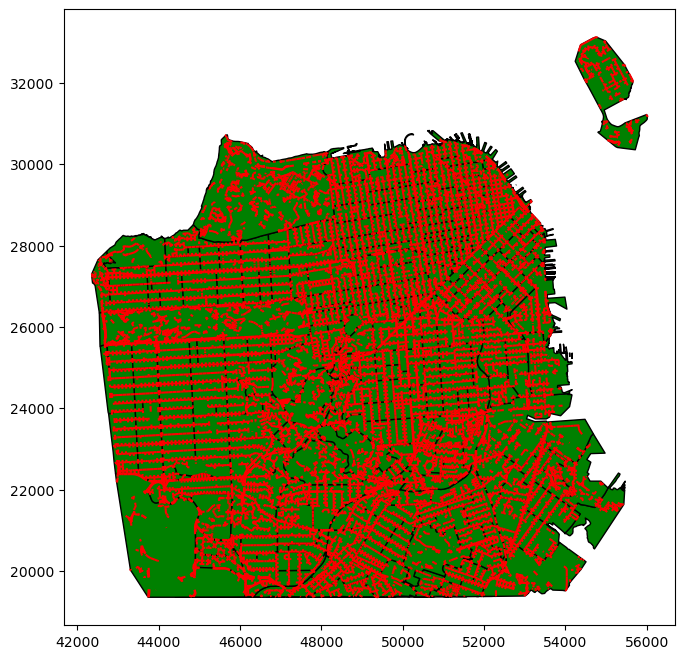

In [66]:
fig, ax = plt.subplots(figsize = (8,8)) 
census_track2_sf.plot(ax=ax,color="green",edgecolor='k')
sf_lts.geometry.plot(color="red",edgecolor='k',ax=ax)

In [67]:
input_census_tract=census_track2_sf.reset_index()
input_census_tract.shape

(248, 18)

In [68]:
def grid_connectivity_score (input_census_tract,sf_motor_network,sf_bike_network):
    
    connectivity_score=[]

    for index, row in input_census_tract.iterrows():
        network_motor=gpd.clip(sf_motor_network,row['geometry'])
        sf_lts_motor_g=gpd.GeoDataFrame.explode(network_motor)
        sf_lts_motor_g1 =momepy.gdf_to_nx(sf_lts_motor_g, approach='primal')
        #https://www.programcreek.com/python/example/120188/networkx.all_pairs_dijkstra_path_length
        motor_length = dict(nx.all_pairs_dijkstra_path_length(sf_lts_motor_g1,cutoff=None, weight='impedance_of_link'))
        # Convert the shorsted path distance distionary to dataframe
        sf_shortest_path_motor_length=pd.DataFrame.from_dict(motor_length)
        # Calculate the total motor path
        sf_shortest_path_motor_length['total']=sf_shortest_path_motor_length.sum(numeric_only=True, axis=0)
        sf_shortest_path_motor_length_sum=sf_shortest_path_motor_length['total'].sum()



        network_bike=gpd.clip(sf_bike_network,row['geometry'])
        sf_lts_bike_g=gpd.GeoDataFrame.explode(network_bike)
        sf_lts_bike_g1 =momepy.gdf_to_nx(sf_lts_bike_g, approach='primal')
        #https://www.programcreek.com/python/example/120188/networkx.all_pairs_dijkstra_path_length
        bike_length = dict(nx.all_pairs_dijkstra_path_length(sf_lts_bike_g1,cutoff=None, weight='impedance_of_link'))
        # Convert the shorsted path distance distionary to dataframe
        sf_shortest_path_bike_length=pd.DataFrame.from_dict(bike_length)
        # Calculate the total motor path
        sf_shortest_path_bike_length['total']=sf_shortest_path_bike_length.sum(numeric_only=True, axis=0)
        sf_shortest_path_bike_length_sum=sf_shortest_path_bike_length['total'].sum()

        #connectivity score
        sf_network_connectivity_score=sf_shortest_path_bike_length_sum/sf_shortest_path_motor_length_sum
        connectivity_score.append((sf_shortest_path_motor_length_sum,sf_shortest_path_bike_length_sum, sf_network_connectivity_score))

    cols=['motor_path_weighted_length','bike_path_weighted_length','Connectivity score']
    result = pd.DataFrame(connectivity_score, columns=cols)
    return result


In [69]:
%%time
SF_CS=grid_connectivity_score (input_census_tract,sf_motor_network,sf_bike_network)
SF_CS.head()

C:\Users\mmmiah\AppData\Local\Temp\ipykernel_16188\4171608999.py:7: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd.GeoDataFrame.explode(network_motor)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_16188\4171608999.py:20: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_bike_g=gpd.GeoDataFrame.explode(network_bike)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_16188\4171608999.py:31: RuntimeWarning: invalid value encountered in double_scalars
  sf_network_connectivity_score=sf_shortest_path_bike_length_sum/sf_shortest_path_motor_length_sum
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_16188\4171608999.py:7: FutureWarning

C:\Users\mmmiah\AppData\Local\Temp\ipykernel_16188\4171608999.py:7: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd.GeoDataFrame.explode(network_motor)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_16188\4171608999.py:20: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_bike_g=gpd.GeoDataFrame.explode(network_bike)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_16188\4171608999.py:7: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd

C:\Users\mmmiah\AppData\Local\Temp\ipykernel_16188\4171608999.py:7: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd.GeoDataFrame.explode(network_motor)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_16188\4171608999.py:20: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_bike_g=gpd.GeoDataFrame.explode(network_bike)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_16188\4171608999.py:7: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd

C:\Users\mmmiah\AppData\Local\Temp\ipykernel_16188\4171608999.py:20: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_bike_g=gpd.GeoDataFrame.explode(network_bike)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_16188\4171608999.py:7: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd.GeoDataFrame.explode(network_motor)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_16188\4171608999.py:20: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_bike_g=gpd

C:\Users\mmmiah\AppData\Local\Temp\ipykernel_16188\4171608999.py:20: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_bike_g=gpd.GeoDataFrame.explode(network_bike)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_16188\4171608999.py:7: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd.GeoDataFrame.explode(network_motor)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_16188\4171608999.py:20: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_bike_g=gpd

C:\Users\mmmiah\AppData\Local\Temp\ipykernel_16188\4171608999.py:20: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_bike_g=gpd.GeoDataFrame.explode(network_bike)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_16188\4171608999.py:7: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd.GeoDataFrame.explode(network_motor)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_16188\4171608999.py:20: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_bike_g=gpd

C:\Users\mmmiah\AppData\Local\Temp\ipykernel_16188\4171608999.py:7: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd.GeoDataFrame.explode(network_motor)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_16188\4171608999.py:20: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_bike_g=gpd.GeoDataFrame.explode(network_bike)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_16188\4171608999.py:7: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd

C:\Users\mmmiah\AppData\Local\Temp\ipykernel_16188\4171608999.py:20: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_bike_g=gpd.GeoDataFrame.explode(network_bike)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_16188\4171608999.py:7: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd.GeoDataFrame.explode(network_motor)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_16188\4171608999.py:20: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_bike_g=gpd

C:\Users\mmmiah\AppData\Local\Temp\ipykernel_16188\4171608999.py:7: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd.GeoDataFrame.explode(network_motor)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_16188\4171608999.py:20: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_bike_g=gpd.GeoDataFrame.explode(network_bike)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_16188\4171608999.py:7: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd

C:\Users\mmmiah\AppData\Local\Temp\ipykernel_16188\4171608999.py:7: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd.GeoDataFrame.explode(network_motor)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_16188\4171608999.py:20: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_bike_g=gpd.GeoDataFrame.explode(network_bike)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_16188\4171608999.py:7: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd

C:\Users\mmmiah\AppData\Local\Temp\ipykernel_16188\4171608999.py:20: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_bike_g=gpd.GeoDataFrame.explode(network_bike)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_16188\4171608999.py:7: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd.GeoDataFrame.explode(network_motor)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_16188\4171608999.py:20: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_bike_g=gpd

C:\Users\mmmiah\AppData\Local\Temp\ipykernel_16188\4171608999.py:7: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd.GeoDataFrame.explode(network_motor)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_16188\4171608999.py:20: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_bike_g=gpd.GeoDataFrame.explode(network_bike)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_16188\4171608999.py:7: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd

C:\Users\mmmiah\AppData\Local\Temp\ipykernel_16188\4171608999.py:7: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd.GeoDataFrame.explode(network_motor)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_16188\4171608999.py:20: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_bike_g=gpd.GeoDataFrame.explode(network_bike)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_16188\4171608999.py:7: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd

C:\Users\mmmiah\AppData\Local\Temp\ipykernel_16188\4171608999.py:20: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_bike_g=gpd.GeoDataFrame.explode(network_bike)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_16188\4171608999.py:7: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd.GeoDataFrame.explode(network_motor)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_16188\4171608999.py:20: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_bike_g=gpd

C:\Users\mmmiah\AppData\Local\Temp\ipykernel_16188\4171608999.py:7: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd.GeoDataFrame.explode(network_motor)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_16188\4171608999.py:20: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_bike_g=gpd.GeoDataFrame.explode(network_bike)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_16188\4171608999.py:7: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd

C:\Users\mmmiah\AppData\Local\Temp\ipykernel_16188\4171608999.py:20: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_bike_g=gpd.GeoDataFrame.explode(network_bike)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_16188\4171608999.py:7: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd.GeoDataFrame.explode(network_motor)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_16188\4171608999.py:20: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_bike_g=gpd

C:\Users\mmmiah\AppData\Local\Temp\ipykernel_16188\4171608999.py:7: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd.GeoDataFrame.explode(network_motor)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_16188\4171608999.py:20: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_bike_g=gpd.GeoDataFrame.explode(network_bike)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_16188\4171608999.py:7: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd

C:\Users\mmmiah\AppData\Local\Temp\ipykernel_16188\4171608999.py:7: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd.GeoDataFrame.explode(network_motor)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_16188\4171608999.py:20: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_bike_g=gpd.GeoDataFrame.explode(network_bike)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_16188\4171608999.py:7: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd

C:\Users\mmmiah\AppData\Local\Temp\ipykernel_16188\4171608999.py:7: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd.GeoDataFrame.explode(network_motor)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_16188\4171608999.py:20: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_bike_g=gpd.GeoDataFrame.explode(network_bike)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_16188\4171608999.py:7: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd

CPU times: total: 18.2 s
Wall time: 18.2 s


C:\Users\mmmiah\AppData\Local\Temp\ipykernel_16188\4171608999.py:7: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd.GeoDataFrame.explode(network_motor)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_16188\4171608999.py:20: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_bike_g=gpd.GeoDataFrame.explode(network_bike)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_16188\4171608999.py:7: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd

,motor_path_weighted_length,bike_path_weighted_length,Connectivity score
0,0.000000e+00,0.000000,NaN
1,1.482155e+03,317.258996,0.214053
2,4.322773e+05,541.623346,0.001253
3,1.944088e+06,164249.068853,0.084486
4,1.441747e+06,632.767523,0.000439


In [70]:
# Now jointhe connectivity score with census track and save it

In [71]:
cs_census_track=pd.merge(SF_CS, input_census_tract, left_index=True, right_index=True)
cs_census_track.head()

,motor_path_weighted_length,bike_path_weighted_length,Connectivity score,index,GISJOIN,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,...,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,Shape_Leng,Shape_Le_1,Shape_Area,geometry
0,0.000000e+00,0.000000,NaN,980,G0600810600100,06,081,600100,06081600100,6001,...,G5020,S,14582823.0,2117772.0,+37.6877413,-122.4084093,21931.580332,21901.907257,1.502156e+07,"MULTIPOLYGON (((51990.049 19375.144, 51996.133..."
1,1.482155e+03,317.258996,0.214053,981,G0600810600200,06,081,600200,06081600200,6002,...,G5020,S,1137963.0,0.0,+37.7044761,-122.4157978,5484.725579,5484.726024,1.137960e+06,"MULTIPOLYGON (((50662.857 19364.399, 50717.529..."
2,4.322773e+05,541.623346,0.001253,891,G0600750026404,06,075,026404,06075026404,264.04,...,G5020,S,189179.0,0.0,+37.7096507,-122.4152933,2097.988325,2097.988325,1.891781e+05,"POLYGON ((51353.615 19473.311, 51330.274 19407..."
3,1.944088e+06,164249.068853,0.084486,890,G0600750026403,06,075,026403,06075026403,264.03,...,G5020,S,379501.0,0.0,+37.7111907,-122.4069124,3003.969753,3003.969753,3.795004e+05,"POLYGON ((52162.578 19802.437, 52134.636 19783..."
4,1.441747e+06,632.767523,0.000439,888,G0600750026401,06,075,026401,06075026401,264.01,...,G5020,S,341043.0,0.0,+37.7135251,-122.4112834,2825.654952,2825.654952,3.410432e+05,"POLYGON ((51495.157 20270.624, 51532.106 20257..."


In [72]:
cs_census_track['Connectivity score'].median()

0.05648850659235223

In [73]:
crs = {'init': 'epsg:7131'}
gdf = gpd.GeoDataFrame(cs_census_track, crs=crs, geometry = 'geometry')
gdf.to_file("H:/Desktop/Bicycle Connectivity Project/Project-Bicycle Connectivity/Bay Area_LTS/SF_Census_track_level_seg_cross_CS.shp")

C:\Users\mmmiah\.conda\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_16188\3415543774.py:3: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf.to_file("H:/Desktop/Bicycle Connectivity Project/Project-Bicycle Connectivity/Bay Area_LTS/SF_Census_track_level_seg_cross_CS.shp")


# Consider high Stress Vs Low Stress connectivity: using Formula "Shortest Path(LTS1+LTS2)/Shortest Path (LTS1+LTS2+LTS3+LTS4-All Bicycle Facilities)

In [74]:
# comments: Here all high stress is changed to Motor Network

In [75]:
# Split the network as low VS high stress network to get the connectivity by stress level
sf_motor_network_op2=sf_motor_network
sf_bike_network_op2=sf_lts.loc[sf_lts['Stress']<3]

In [76]:
# %%time
# # low stress connectivity
# low_stress_network_score=graph_parameter(sf_bike_network_op2,415,convex_hull_area1,sf_area)
# low_stress_network_score['mode']='low_stress'
# low_stress_network_score

In [77]:
# %%time
# # motor network  connectivity
# high_stress_network_score=graph_parameter(sf_motor_network_op2,1102,convex_hull_area1,sf_area)
# high_stress_network_score['mode']='Motor Network'
# high_stress_network_score

In [78]:
%%time
# low stress Vs motor network connectivity score
## Calculate the connectivity score for bike vs motor network condition
low_high_stress_CS=sf_connectivity_score (sf_motor_network_op2,sf_bike_network_op2)
low_high_stress_CS

C:\Users\mmmiah\AppData\Local\Temp\ipykernel_16188\2561783953.py:3: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd.GeoDataFrame.explode(sf_motor_network)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_16188\2561783953.py:14: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_bike_g=gpd.GeoDataFrame.explode(sf_bike_network)


CPU times: total: 3min 15s
Wall time: 3min 15s


,motor_path_weighted_length,bike_path_weighted_length,Connectivity score
0,4.301544e+10,3.158258e+10,0.734215


In [79]:
%%time
# Calculate the census level stress for high vs low stress network
SF_CS_hl=grid_connectivity_score (input_census_tract,sf_bike_network_op2,sf_motor_network_op2)
SF_CS_hl.head()

C:\Users\mmmiah\AppData\Local\Temp\ipykernel_16188\4171608999.py:7: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd.GeoDataFrame.explode(network_motor)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_16188\4171608999.py:20: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_bike_g=gpd.GeoDataFrame.explode(network_bike)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_16188\4171608999.py:31: RuntimeWarning: invalid value encountered in double_scalars
  sf_network_connectivity_score=sf_shortest_path_bike_length_sum/sf_shortest_path_motor_length_sum
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_16188\4171608999.py:7: FutureWarning

C:\Users\mmmiah\AppData\Local\Temp\ipykernel_16188\4171608999.py:20: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_bike_g=gpd.GeoDataFrame.explode(network_bike)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_16188\4171608999.py:7: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd.GeoDataFrame.explode(network_motor)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_16188\4171608999.py:20: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_bike_g=gpd

C:\Users\mmmiah\AppData\Local\Temp\ipykernel_16188\4171608999.py:20: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_bike_g=gpd.GeoDataFrame.explode(network_bike)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_16188\4171608999.py:7: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd.GeoDataFrame.explode(network_motor)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_16188\4171608999.py:20: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_bike_g=gpd

C:\Users\mmmiah\AppData\Local\Temp\ipykernel_16188\4171608999.py:7: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd.GeoDataFrame.explode(network_motor)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_16188\4171608999.py:20: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_bike_g=gpd.GeoDataFrame.explode(network_bike)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_16188\4171608999.py:7: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd

C:\Users\mmmiah\AppData\Local\Temp\ipykernel_16188\4171608999.py:20: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_bike_g=gpd.GeoDataFrame.explode(network_bike)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_16188\4171608999.py:7: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd.GeoDataFrame.explode(network_motor)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_16188\4171608999.py:20: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_bike_g=gpd

C:\Users\mmmiah\AppData\Local\Temp\ipykernel_16188\4171608999.py:7: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd.GeoDataFrame.explode(network_motor)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_16188\4171608999.py:20: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_bike_g=gpd.GeoDataFrame.explode(network_bike)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_16188\4171608999.py:7: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd

C:\Users\mmmiah\AppData\Local\Temp\ipykernel_16188\4171608999.py:20: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_bike_g=gpd.GeoDataFrame.explode(network_bike)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_16188\4171608999.py:7: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd.GeoDataFrame.explode(network_motor)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_16188\4171608999.py:20: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_bike_g=gpd

C:\Users\mmmiah\AppData\Local\Temp\ipykernel_16188\4171608999.py:20: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_bike_g=gpd.GeoDataFrame.explode(network_bike)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_16188\4171608999.py:7: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd.GeoDataFrame.explode(network_motor)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_16188\4171608999.py:20: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_bike_g=gpd

C:\Users\mmmiah\AppData\Local\Temp\ipykernel_16188\4171608999.py:20: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_bike_g=gpd.GeoDataFrame.explode(network_bike)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_16188\4171608999.py:7: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd.GeoDataFrame.explode(network_motor)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_16188\4171608999.py:20: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_bike_g=gpd

C:\Users\mmmiah\AppData\Local\Temp\ipykernel_16188\4171608999.py:7: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd.GeoDataFrame.explode(network_motor)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_16188\4171608999.py:20: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_bike_g=gpd.GeoDataFrame.explode(network_bike)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_16188\4171608999.py:7: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd

C:\Users\mmmiah\AppData\Local\Temp\ipykernel_16188\4171608999.py:7: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd.GeoDataFrame.explode(network_motor)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_16188\4171608999.py:20: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_bike_g=gpd.GeoDataFrame.explode(network_bike)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_16188\4171608999.py:7: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd

C:\Users\mmmiah\AppData\Local\Temp\ipykernel_16188\4171608999.py:7: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd.GeoDataFrame.explode(network_motor)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_16188\4171608999.py:20: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_bike_g=gpd.GeoDataFrame.explode(network_bike)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_16188\4171608999.py:7: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd

C:\Users\mmmiah\AppData\Local\Temp\ipykernel_16188\4171608999.py:7: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd.GeoDataFrame.explode(network_motor)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_16188\4171608999.py:20: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_bike_g=gpd.GeoDataFrame.explode(network_bike)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_16188\4171608999.py:7: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd

C:\Users\mmmiah\AppData\Local\Temp\ipykernel_16188\4171608999.py:7: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd.GeoDataFrame.explode(network_motor)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_16188\4171608999.py:20: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_bike_g=gpd.GeoDataFrame.explode(network_bike)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_16188\4171608999.py:7: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd

C:\Users\mmmiah\AppData\Local\Temp\ipykernel_16188\4171608999.py:7: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd.GeoDataFrame.explode(network_motor)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_16188\4171608999.py:20: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_bike_g=gpd.GeoDataFrame.explode(network_bike)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_16188\4171608999.py:7: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd

C:\Users\mmmiah\AppData\Local\Temp\ipykernel_16188\4171608999.py:7: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd.GeoDataFrame.explode(network_motor)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_16188\4171608999.py:20: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_bike_g=gpd.GeoDataFrame.explode(network_bike)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_16188\4171608999.py:7: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd

C:\Users\mmmiah\AppData\Local\Temp\ipykernel_16188\4171608999.py:20: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_bike_g=gpd.GeoDataFrame.explode(network_bike)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_16188\4171608999.py:7: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd.GeoDataFrame.explode(network_motor)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_16188\4171608999.py:20: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_bike_g=gpd

C:\Users\mmmiah\AppData\Local\Temp\ipykernel_16188\4171608999.py:20: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_bike_g=gpd.GeoDataFrame.explode(network_bike)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_16188\4171608999.py:7: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd.GeoDataFrame.explode(network_motor)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_16188\4171608999.py:20: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_bike_g=gpd

C:\Users\mmmiah\AppData\Local\Temp\ipykernel_16188\4171608999.py:7: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd.GeoDataFrame.explode(network_motor)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_16188\4171608999.py:20: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_bike_g=gpd.GeoDataFrame.explode(network_bike)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_16188\4171608999.py:7: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd

CPU times: total: 23.8 s
Wall time: 23.8 s


,motor_path_weighted_length,bike_path_weighted_length,Connectivity score
0,0.000000e+00,0.000000e+00,NaN
1,1.799414e+03,1.482155e+03,0.823688
2,4.248986e+05,4.322773e+05,1.017366
3,1.814823e+06,1.944088e+06,1.071228
4,1.472212e+06,1.441747e+06,0.979307


In [80]:
SF_CS_hl['Connectivity score'].median()

1.3496009975613479

In [81]:
cs_census_track_hl=pd.merge(SF_CS_hl, input_census_tract, left_index=True, right_index=True)
crs = {'init': 'epsg:7131'}
gdf_hl = gpd.GeoDataFrame(cs_census_track_hl, crs=crs, geometry = 'geometry')
gdf_hl.to_file("H:/Desktop/Bicycle Connectivity Project/Project-Bicycle Connectivity/Bay Area_LTS/SF_Census_track_level_seg_cross_CS_low_vs_motor.shp")

C:\Users\mmmiah\.conda\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_16188\2212606321.py:4: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_hl.to_file("H:/Desktop/Bicycle Connectivity Project/Project-Bicycle Connectivity/Bay Area_LTS/SF_Census_track_level_seg_cross_CS_low_vs_motor.shp")


# Calculate Advanced graph Connectivity

## Degree Centrality

In [73]:
# Calculate the Connectivity By LTS classification
sf_motor_network_op2=sf_motor_network
# Convert the LTS shape file to graph to run the 
sf_lts_motor_g_op2=gpd.GeoDataFrame.explode(sf_motor_network_op2)
sf_lts_motor_g1_op2 =momepy.gdf_to_nx(sf_lts_motor_g_op2, approach='primal')

C:\Users\mmmiah\AppData\Local\Temp\ipykernel_34476\1554712526.py:4: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g_op2=gpd.GeoDataFrame.explode(sf_motor_network_op2)


In [74]:
degree = dict(nx.degree(sf_lts_motor_g1_op2))
nx.set_node_attributes(sf_lts_motor_g1_op2, degree, 'degree')

In [75]:
from numpy import array
print('min_dc:', array([degree[k] for k in degree]).min())
print('mean_dc:',array([degree[k] for k in degree]).mean())
print('max_dc:',array([degree[k] for k in degree]).max())
print('std_dc:',array([degree[k] for k in degree]).std())

min_dc: 1
mean_dc: 2.3887585205050845
max_dc: 6
std_dc: 0.8897492434946724


In [76]:
nodes, edges = momepy.nx_to_gdf(sf_lts_motor_g1_op2)

In [77]:
edges=edges.drop(['geometry_x', 'start_lon', 'start_lat', 'starting_ele','geometry_y', 'end_lon', 'end_lat','starting point', 'ending point',],axis=1)

In [78]:
nodes.to_file("H:/Desktop/Bicycle Connectivity Project/Project-Bicycle Connectivity/Bay Area_LTS/SF Analysis/degree_nodes_sf_motor_network.shp")
edges.to_file("H:/Desktop/Bicycle Connectivity Project/Project-Bicycle Connectivity/Bay Area_LTS/SF Analysis/degree_edges_sf_motor_network.shp")

C:\Users\mmmiah\AppData\Local\Temp\ipykernel_34476\2125986196.py:2: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  edges.to_file("H:/Desktop/Bicycle Connectivity Project/Project-Bicycle Connectivity/Bay Area_LTS/SF Analysis/degree_edges_sf_motor_network.shp")


In [ ]:
nodes.shape, edges.shape

In [214]:
### Lets do the same thing for low stress
# Calculate the Connectivity By LTS classification
sf_bike_network_op2=sf_lts.loc[sf_lts['FT_SEG_STR']<3]
# Convert the LTS shape file to graph to run the 
sf_lts_bike_g_op2=gpd.GeoDataFrame.explode(sf_bike_network_op2)
sf_lts_bike_g1_op2 =momepy.gdf_to_nx(sf_lts_bike_g_op2, approach='primal')

C:\Users\mmmiah\AppData\Local\Temp\ipykernel_17096\1843893756.py:5: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_bike_g_op2=gpd.GeoDataFrame.explode(sf_bike_network_op2)


In [215]:
degreel = dict(nx.degree(sf_lts_bike_g1_op2))
nx.set_node_attributes(sf_lts_bike_g1_op2, degreel, 'degree')

In [217]:
nodesl, edgesl = momepy.nx_to_gdf(sf_lts_bike_g1_op2)
edgesl=edgesl.drop(['geometry_x', 'start_lon', 'start_lat', 'starting_ele','geometry_y', 'end_lon', 'end_lat','starting point', 'ending point',],axis=1)

In [218]:
nodesl.to_file("H:/Desktop/Bicycle Connectivity Project/Project-Bicycle Connectivity/Bay Area_LTS/SF Analysis/degree_nodes_ls_sf.shp")
edgesl.to_file("H:/Desktop/Bicycle Connectivity Project/Project-Bicycle Connectivity/Bay Area_LTS/SF Analysis/degree_edges_ls_sf.shp")

C:\Users\mmmiah\AppData\Local\Temp\ipykernel_17096\412474853.py:2: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  edgesl.to_file("H:/Desktop/Bicycle Connectivity Project/Project-Bicycle Connectivity/Bay Area_LTS/SF Analysis/degree_edges_ls_sf.shp")


In [219]:
nodesl.shape, edgesl.shape

((15835, 3), (17474, 33))

In [69]:
%%time
# run the Degree centrality for complete Network
degree2 = dict(nx.degree(sf_lts_g1))
nx.set_node_attributes(sf_lts_g1, degree2, 'degree')
nodes2, edges2 = momepy.nx_to_gdf(sf_lts_g1)
edges2=edges2.drop(['geometry_x', 'start_lon', 'start_lat', 'starting_ele','geometry_y', 'end_lon', 'end_lat','starting point', 'ending point',],axis=1)
#nodes2.to_file("H:/Desktop/Bicycle Connectivity Project/Project-Bicycle Connectivity/Bay Area_LTS/SF Analysis/degree_nodes_sf_complete_network.shp")
#edges2.to_file("H:/Desktop/Bicycle Connectivity Project/Project-Bicycle Connectivity/Bay Area_LTS/SF Analysis/degree_edges_sf_complete_network.shp")

CPU times: total: 1.86 s
Wall time: 1.85 s


In [70]:
from numpy import array
print('min_dc:', array([degree2[k] for k in degree2]).min())
print('mean_dc:',array([degree2[k] for k in degree2]).mean())
print('max_dc:',array([degree2[k] for k in degree2]).max())
print('std_dc:',array([degree2[k] for k in degree2]).std())

min_dc: 1
mean_dc: 2.5771688698240394
max_dc: 7
std_dc: 0.9094870737915214


In [71]:
nodes2.shape, edges2.shape

((22846, 3), (29439, 33))

# Lets Calculate th LTS weighted Eigenvector Centrality

In [95]:
%%time
D = ox.utils_graph.get_digraph(sf_lts_bike_g1_op2, weight="impedance_of_link")
Eigene_centrality_ls = nx.eigenvector_centrality(D,weight="impedance_of_link",max_iter=10000)
nx.set_node_attributes(sf_lts_bike_g1_op2, values=Eigene_centrality_ls, name="Eigene_centrality")

NameError: name 'sf_lts_bike_g1_op2' is not defined

In [228]:
nodes_ecl, edges_ecl = momepy.nx_to_gdf(sf_lts_bike_g1_op2)


In [231]:
edges_ecl=edges_ecl.drop(['geometry_x', 'start_lon', 'start_lat', 'starting_ele','geometry_y', 'end_lon', 'end_lat','starting point', 'ending point',],axis=1)

In [253]:
nodes_ecl['EC_group'] = pd.cut(nodes_ecl['Eigene_centrality'], bins=5, labels=False)+1 
nodes_ecl.tail()

,degree,nodeID,Eigene_centrality,geometry,EC_group
15830,2,15830,0.0,POINT (49229.458 30294.719),1
15831,1,15831,0.0,POINT (49245.423 30297.263),1
15832,2,15832,0.0,POINT (49800.463 30317.500),1
15833,2,15833,0.0,POINT (49584.846 30338.101),1
15834,1,15834,0.0,POINT (49773.666 30395.490),1


In [259]:
ecd=nodes_ecl.loc[nodes_ecl['Eigene_centrality']>0]
ecd['Eigene_centrality'].mean()

0.0629237703998313

In [255]:
nodes_ecl.shape

(15835, 5)

In [235]:
nodes_ecl.groupby(['EC_group'])['Eigene_centrality'].mean()

EC_group
1    0.000002
5    0.706699
Name: Eigene_centrality, dtype: float64

In [232]:
nodes_ecl.to_file("H:/Desktop/Bicycle Connectivity Project/Project-Bicycle Connectivity/Bay Area_LTS/SF Analysis/EC_nodes_ls_sf.shp")
edges_ecl.to_file("H:/Desktop/Bicycle Connectivity Project/Project-Bicycle Connectivity/Bay Area_LTS/SF Analysis/EC_edges_ls_sf.shp")

C:\Users\mmmiah\AppData\Local\Temp\ipykernel_17096\3728937356.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  nodes_ecl.to_file("H:/Desktop/Bicycle Connectivity Project/Project-Bicycle Connectivity/Bay Area_LTS/SF Analysis/EC_nodes_ls_sf.shp")
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_17096\3728937356.py:2: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  edges_ecl.to_file("H:/Desktop/Bicycle Connectivity Project/Project-Bicycle Connectivity/Bay Area_LTS/SF Analysis/EC_edges_ls_sf.shp")


In [ ]:
# Lets Do it for high Stress

In [260]:
D1 = ox.utils_graph.get_digraph(sf_lts_motor_g1_op2, weight="impedance_of_link")

In [261]:
Eigene_centrality_hs = nx.eigenvector_centrality(D,weight="impedance_of_link",max_iter=10000)
nx.set_node_attributes(sf_lts_motor_g1_op2, values=Eigene_centrality_hs, name="Eigene_centrality")

In [262]:
nodes_ech, edges_ech = momepy.nx_to_gdf(sf_lts_motor_g1_op2)

In [263]:
edges_ech=edges_ech.drop(['geometry_x', 'start_lon', 'start_lat', 'starting_ele','geometry_y', 'end_lon', 'end_lat','starting point', 'ending point',],axis=1)

In [271]:
nodes_ech['EC_group'] = pd.cut(nodes_ech['Eigene_centrality'], bins=5, labels=False)+1 
nodes_ech.head(20)

,degree,nodeID,Eigene_centrality,geometry,EC_group
0,3,0,NaN,POINT (43319.112 21173.421),NaN
1,2,1,NaN,POINT (43562.119 20568.580),NaN
2,2,2,0.0,POINT (42801.807 24313.960),1.0
3,2,3,0.0,POINT (42843.850 23901.452),1.0
4,2,4,0.0,POINT (42854.409 23902.433),1.0
5,2,5,0.0,POINT (42812.109 24315.075),1.0
6,2,6,NaN,POINT (43750.290 19550.253),NaN
7,1,7,NaN,POINT (43738.794 19354.081),NaN
8,2,8,NaN,POINT (49705.230 19374.634),NaN
9,1,9,NaN,POINT (49640.981 19364.176),NaN


In [265]:
nodes_ech.groupby(['EC_group'])['Eigene_centrality'].mean()

EC_group
1.0    0.000000
5.0    0.000385
Name: Eigene_centrality, dtype: float64

In [266]:
ecd1=nodes_ech.loc[nodes_ech['Eigene_centrality']>0]
ecd1['Eigene_centrality'].mean()

0.00019270853623909313

In [272]:
nodes_ech.shape

(10849, 5)

In [268]:
nodes_ech.to_file("H:/Desktop/Bicycle Connectivity Project/Project-Bicycle Connectivity/Bay Area_LTS/SF Analysis/EC_nodes_hs_sf.shp")
edges_ech.to_file("H:/Desktop/Bicycle Connectivity Project/Project-Bicycle Connectivity/Bay Area_LTS/SF Analysis/EC_edges_hs_sf.shp")

C:\Users\mmmiah\AppData\Local\Temp\ipykernel_17096\212227437.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  nodes_ech.to_file("H:/Desktop/Bicycle Connectivity Project/Project-Bicycle Connectivity/Bay Area_LTS/SF Analysis/EC_nodes_hs_sf.shp")
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_17096\212227437.py:2: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  edges_ech.to_file("H:/Desktop/Bicycle Connectivity Project/Project-Bicycle Connectivity/Bay Area_LTS/SF Analysis/EC_edges_hs_sf.shp")


In [ ]:
## Run the EC for the Entire Network

In [274]:
%%time
D2 = ox.utils_graph.get_digraph(sf_lts_g1, weight="impedance_of_link")
Eigene_centrality_cn = nx.eigenvector_centrality(D2,weight="impedance_of_link",max_iter=10000)
nx.set_node_attributes(sf_lts_g1, values=Eigene_centrality_cn, name="Eigene_centrality")
nodes_ec2, edges_ec2 = momepy.nx_to_gdf(sf_lts_g1)
edges_ec2=edges_ec2.drop(['geometry_x', 'start_lon', 'start_lat', 'starting_ele','geometry_y', 'end_lon', 'end_lat','starting point', 'ending point',],axis=1)

CPU times: total: 7min 56s
Wall time: 7min 56s


In [275]:
nodes_ec2['EC_group'] = pd.cut(nodes_ec2['Eigene_centrality'], bins=5, labels=False)+1 
nodes_ec2.tail()

,degree,nodeID,Eigene_centrality,geometry,EC_group
22841,2,22841,1.665591e-137,POINT (49229.458 30294.719),1
22842,1,22842,1.900274e-139,POINT (49245.423 30297.263),1
22843,2,22843,1.630704e-126,POINT (49800.463 30317.500),1
22844,2,22844,0.000000e+00,POINT (49584.846 30338.101),1
22845,1,22845,0.000000e+00,POINT (49773.666 30395.490),1


In [276]:
nodes_ec2.groupby(['EC_group'])['Eigene_centrality'].mean()

EC_group
1    0.000002
5    0.706689
Name: Eigene_centrality, dtype: float64

In [277]:
nodes_ec2.to_file("H:/Desktop/Bicycle Connectivity Project/Project-Bicycle Connectivity/Bay Area_LTS/SF Analysis/EC_nodes_cn_sf.shp")
edges_ec2.to_file("H:/Desktop/Bicycle Connectivity Project/Project-Bicycle Connectivity/Bay Area_LTS/SF Analysis/EC_edges_cn_sf.shp")

C:\Users\mmmiah\AppData\Local\Temp\ipykernel_17096\2501514422.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  nodes_ec2.to_file("H:/Desktop/Bicycle Connectivity Project/Project-Bicycle Connectivity/Bay Area_LTS/SF Analysis/EC_nodes_cn_sf.shp")
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_17096\2501514422.py:2: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  edges_ec2.to_file("H:/Desktop/Bicycle Connectivity Project/Project-Bicycle Connectivity/Bay Area_LTS/SF Analysis/EC_edges_cn_sf.shp")


# Run the closeness centrality for San Francisco 

In [97]:
%%time
# calculate node closeness centrality of the line graph
edge_centrality = nx.closeness_centrality(nx.line_graph(sf_lts_g1),distance="impedance_of_link")
nx.set_edge_attributes(sf_lts_g1, edge_centrality, "edge_centrality")
nodes2, edges2 = momepy.nx_to_gdf(sf_lts_g1)
edges2=edges2.drop(['geometry_x', 'start_lon', 'start_lat', 'starting_ele','geometry_y', 'end_lon', 'end_lat','starting point', 'ending point',],axis=1)

CPU times: total: 1h 41min 14s
Wall time: 1h 41min 18s


In [100]:
from numpy import array
print('min_dc:', array([edge_centrality[k] for k in edge_centrality]).min())
print('mean_dc:',array([edge_centrality[k] for k in edge_centrality]).mean())
print('max_dc:',array([edge_centrality[k] for k in edge_centrality]).max())
print('std_dc:',array([edge_centrality[k] for k in edge_centrality]).std())

min_dc: 0.0
mean_dc: 0.01191540650003893
max_dc: 0.014878685824671018
std_dc: 0.002229109172667111


In [99]:
nodes2.to_file("H:/Desktop/Bicycle Connectivity Project/Project-Bicycle Connectivity/Bay Area_LTS/SF Analysis/CC_nodes_sf.shp")
edges2.to_file("H:/Desktop/Bicycle Connectivity Project/Project-Bicycle Connectivity/Bay Area_LTS/SF Analysis/CC_edges_sf.shp")

C:\Users\mmmiah\AppData\Local\Temp\ipykernel_1088\308363760.py:2: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  edges2.to_file("H:/Desktop/Bicycle Connectivity Project/Project-Bicycle Connectivity/Bay Area_LTS/SF Analysis/CC_edges_sf.shp")


# Run Betweenness Centrality for complete SF Network

In [101]:
%%time
# calculate node betweenness centrality, weighted by travel time
D2_sf = ox.utils_graph.get_digraph(sf_lts_g1, weight="impedance_of_link")
bc = nx.betweenness_centrality(D2_sf, weight="impedance_of_link", normalized=True)
nx.set_node_attributes(sf_lts_g1, values=bc, name="bc")

CPU times: total: 1h 25min 36s
Wall time: 1h 25min 39s


In [102]:
# get the mean closeness centrality
from numpy import array
print('min_ec:', array([bc[k] for k in bc]).min())
print('mean_ec:',array([bc[k] for k in bc]).mean())
print('max_ec:',array([bc[k] for k in bc]).max())
print('std_ec:',array([bc[k] for k in bc]).std())

min_ec: 0.0
mean_ec: 0.0052402285338809425
max_ec: 0.15158680347130876
std_ec: 0.014779400695416696


In [103]:
nodes_bc_sf, edges_bc_sf = momepy.nx_to_gdf(sf_lts_g1)
edges_bc_sf=edges_bc_sf.drop(['geometry_x', 'start_lon', 'start_lat', 'starting_ele','geometry_y', 'end_lon', 'end_lat','starting point', 'ending point',],axis=1)

In [104]:
nodes_bc_sf.to_file("H:/Desktop/Bicycle Connectivity Project/Project-Bicycle Connectivity/Bay Area_LTS/SF Analysis/BC_nodes_sf.shp")
edges_bc_sf.to_file("H:/Desktop/Bicycle Connectivity Project/Project-Bicycle Connectivity/Bay Area_LTS/SF Analysis/BC_edges_sf.shp")

C:\Users\mmmiah\AppData\Local\Temp\ipykernel_1088\2021502790.py:2: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  edges_bc_sf.to_file("H:/Desktop/Bicycle Connectivity Project/Project-Bicycle Connectivity/Bay Area_LTS/SF Analysis/BC_edges_sf.shp")


# Run the Modularity of SF complete Network

In [86]:
%%time
from networkx.algorithms import community
from operator import itemgetter
communities = community.greedy_modularity_communities(sf_lts_g1)

CPU times: total: 4.77 s
Wall time: 4.77 s


In [82]:
modularity_dict = {} # Create a blank dictionary
for i,c in enumerate(communities): # Loop through the list of communities, keeping track of the number for the community
    for name in c: # Loop through each person in a community
        modularity_dict[name] = i # Create an entry in the dictionary for the person, where the value is which group they belong to.

# Now you can add modularity information like we did the other metrics
nx.set_node_attributes(sf_lts_g1, modularity_dict, 'modularity')

In [84]:
nodes_m_sf, edges_m_sf = momepy.nx_to_gdf(sf_lts_g1)
edges_m_sf=edges_m_sf.drop(['geometry_x', 'start_lon', 'start_lat', 'starting_ele','geometry_y', 'end_lon', 'end_lat','starting point', 'ending point',],axis=1)

In [85]:
nodes_m_sf.to_file("H:/Desktop/Bicycle Connectivity Project/Project-Bicycle Connectivity/Bay Area_LTS/SF Analysis/m_nodes_sf.shp")
edges_m_sf.to_file("H:/Desktop/Bicycle Connectivity Project/Project-Bicycle Connectivity/Bay Area_LTS/SF Analysis/m_edges_sf.shp")

C:\Users\mmmiah\AppData\Local\Temp\ipykernel_34476\922155923.py:2: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  edges_m_sf.to_file("H:/Desktop/Bicycle Connectivity Project/Project-Bicycle Connectivity/Bay Area_LTS/SF Analysis/m_edges_sf.shp")


# Run the Degree Centrality for Entire Bay Area

In [55]:
barea_all2 = gpd.GeoDataFrame(barea_all1, crs="EPSG:4326", geometry='geometry')
barea_all3=barea_all2.to_crs(epsg=7131)
barea_all3.head()

,ROAD_ID,geometry_x,start_lon,start_lat,starting_ele,geometry_y,end_lon,end_lat,ending_ele,osmid,...,FT_INT_STR,TF_SEG_STR,TF_INT_STR,XWALK,geometry,length,starting point,ending point,slope,impedance_of_link
0,111276,POINT (-121.95749310000001 37.523941700000016),-121.957493,37.523942,13,POINT (-121.9572184 37.52396300000001),-121.957218,37.523963,13,{31439803},...,0,0,3.0,0,"LINESTRING (91536.677 -976.326, 91560.948 -973...",24.398252,POINT (-121.95749310000001 37.523941700000016),POINT (-121.9572184 37.52396300000001),0.000000,121.991261
1,162454,POINT (-121.7691832 37.3146411),-121.769183,37.314641,110,POINT (-121.76834140000001 37.3147661),-121.768341,37.314766,113,{93291777},...,1.0,0,1.0,0,"LINESTRING (108350.827 -24102.437, 108425.349 ...",75.902661,POINT (-121.7691832 37.3146411),POINT (-121.76834140000001 37.3147661),3.952431,407.597287
2,165633,POINT (-121.92277360000001 37.323369199999995),-121.922774,37.323369,36,POINT (-121.9223468 37.3233632),-121.922347,37.323363,36,{184388728},...,1.0,0,1.0,0,"LINESTRING (94730.324 -23220.754, 94768.157 -2...",37.835842,POINT (-121.92277360000001 37.323369199999995),POINT (-121.9223468 37.3233632),0.000000,189.179208
3,888344,POINT (-122.24641819999998 37.78016040000001),-122.246418,37.780160,5,POINT (-122.2464029 37.78016710000001),-122.246403,37.780167,5,{53726448},...,1.0,0,1.0,0,"LINESTRING (65934.473 27367.107, 65935.819 273...",1.539394,POINT (-122.24641819999998 37.78016040000001),POINT (-122.2464029 37.78016710000001),0.000000,7.696969
4,923150,POINT (-122.5192523 38.05433039999999),-122.519252,38.054330,11,POINT (-122.51929420000002 38.0543339),-122.519294,38.054334,11,{655711604},...,0,0,0,0,"LINESTRING (41921.847 57781.540, 41918.170 577...",3.697954,POINT (-122.5192523 38.05433039999999),POINT (-122.51929420000002 38.0543339),0.000000,7.395908


In [57]:
# Convert the LTS shape file to graph to run the 
ba_lts_g=gpd.GeoDataFrame.explode(barea_all3)
ba_lts_g1 =momepy.gdf_to_nx(ba_lts_g, approach='primal')

C:\Users\mmmiah\AppData\Local\Temp\ipykernel_12540\3765985809.py:2: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  ba_lts_g=gpd.GeoDataFrame.explode(barea_all3)


In [60]:
# run the Degree centrality for complete Network
degree_ba = dict(nx.degree(ba_lts_g1))
nx.set_node_attributes(ba_lts_g1, degree_ba, 'degree')
nodes_ba, edges_ba = momepy.nx_to_gdf(ba_lts_g1)
edges_ba=edges_ba.drop(['geometry_x', 'start_lon', 'start_lat', 'starting_ele','geometry_y', 'end_lon', 'end_lat','starting point', 'ending point',],axis=1)
nodes_ba.to_file("H:/Desktop/Bicycle Connectivity Project/Project-Bicycle Connectivity/Bay Area_LTS/degree_nodes_BA_complete_network.shp")
edges_ba.to_file("H:/Desktop/Bicycle Connectivity Project/Project-Bicycle Connectivity/Bay Area_LTS/degree_edges_BA_complete_network.shp")

C:\Users\mmmiah\AppData\Local\Temp\ipykernel_12540\1704521230.py:7: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  edges_ba.to_file("H:/Desktop/Bicycle Connectivity Project/Project-Bicycle Connectivity/Bay Area_LTS/degree_edges_BA_complete_network.shp")


In [63]:
nodes_ba.head()

,degree,nodeID,geometry
0,4,0,POINT (91536.677 -976.326)
1,2,1,POINT (91560.948 -973.835)
2,4,2,POINT (108350.827 -24102.437)
3,4,3,POINT (108425.349 -24088.026)
4,3,4,POINT (94730.324 -23220.754)


In [65]:
nodes_ba.groupby(['degree'])['nodeID'].count()

degree
1     56805
2    192514
3    131132
4     41205
5      1838
6       120
7        13
8         1
Name: nodeID, dtype: int64

# Lets run EC for the entire Bay Area

In [66]:
%%time
D2_ba = ox.utils_graph.get_digraph(ba_lts_g1, weight="impedance_of_link")
Eigene_centrality_ba = nx.eigenvector_centrality(D2_ba,weight="impedance_of_link",max_iter=10000)
nx.set_node_attributes(ba_lts_g1, values=Eigene_centrality_ba, name="Eigene_centrality")
nodes_ec_ba, edges_ec_ba = momepy.nx_to_gdf(ba_lts_g1)
edges_ec_ba=edges_ec_ba.drop(['geometry_x', 'start_lon', 'start_lat', 'starting_ele','geometry_y', 'end_lon', 'end_lat','starting point', 'ending point',],axis=1)

CPU times: total: 4h 21min 12s
Wall time: 4h 21min 18s


In [67]:
nodes_ec_ba['EC_group'] = pd.cut(nodes_ec_ba['Eigene_centrality'], bins=5, labels=False)+1 
nodes_ec_ba.tail()

,degree,nodeID,Eigene_centrality,geometry,EC_group
423623,1,423623,0.000000e+00,POINT (112889.018 228.441),1
423624,1,423624,0.000000e+00,POINT (95188.611 -7877.929),1
423625,1,423625,1.835418e-226,POINT (108281.480 11610.755),1
423626,1,423626,0.000000e+00,POINT (77388.453 12431.058),1
423627,1,423627,0.000000e+00,POINT (95218.860 -7846.680),1


In [68]:
nodes_ec_ba.groupby(['EC_group'])['Eigene_centrality'].mean()

EC_group
1    4.182375e-07
2    2.512563e-01
4    5.586459e-01
5    7.832528e-01
Name: Eigene_centrality, dtype: float64

In [71]:
nodes_ec_ba['Eigene_centrality'].describe()

count    423628.000000
mean          0.000004
std           0.001536
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           0.783253
Name: Eigene_centrality, dtype: float64

In [69]:
nodes_ec_ba.to_file("H:/Desktop/Bicycle Connectivity Project/Project-Bicycle Connectivity/Bay Area_LTS/EC_nodes_cn_BA.shp")
edges_ec_ba.to_file("H:/Desktop/Bicycle Connectivity Project/Project-Bicycle Connectivity/Bay Area_LTS/EC_edges_cn_BA.shp")

C:\Users\mmmiah\AppData\Local\Temp\ipykernel_12540\3327844263.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  nodes_ec_ba.to_file("H:/Desktop/Bicycle Connectivity Project/Project-Bicycle Connectivity/Bay Area_LTS/EC_nodes_cn_BA.shp")
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_12540\3327844263.py:2: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  edges_ec_ba.to_file("H:/Desktop/Bicycle Connectivity Project/Project-Bicycle Connectivity/Bay Area_LTS/EC_edges_cn_BA.shp")


# End of the Code